

---



#                                                    Data description
                                                  
                                                  
---


## Folder Names & Meanings

Each Sub-Class contains 5000 Images

Links are given for the reference Datasets


## Acute Lymphoblastic Leukemia 

all_benign  Benign

all_early   Early

all_pre      Pre

all_pro      Pro



## Brain Cancer 

brain_glioma  Glioma

brain_menin   Meningioma

brain_tumor   Pituitary Tumor

## Breast Cancer 


breast_benign     Benign

breast_malignant  Malignant


## Cervical Cancer 

cervix_dyk     Dyskeratotic

cervix_koc     Koilocytotic

cervix_mep    Metaplastic

cervix_pab     Parabasal

cervix_sfi    Superficial-Intermediat



## Kidney Cancer 

kidney_normal   Normal

kidney_tumor     Tumor

## Lung and Colon Cancer 

colon_aca    Colon Adenocarcinoma

colon_bnt    Colon Benign Tissue

lung_aca     Lung Adenocarcinoma

lung_bnt     Lung Benign Tissue

lung_scc      Lung Squamous Cell Carcinoma


## Lymphoma 

lymph_cll    Chronic Lymphocytic Leukemia

lymph_fl    Follicular Lymphoma

lymph_mcl   Mantle Cell Lymphoma


## Oral Cancer 

oral_normal   Normal

oral_scc      Oral Squamous Cell Carcinoma



---




Main Classes   -   8

Sub Classes   -   26

Format   -   JPEG

Dimensions   -   512px X 512px



---

# Directory



In [25]:
base_path='Multi Cancer/'

# import needed libraries 

In [26]:
from keras.layers import Input, Lambda, Dense, Flatten
from skimage.io import imshow,imread
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils import plot_model
from keras.utils import model_to_dot
import pandas as pd
from IPython.display import SVG

# initiate image size vriables

In [27]:
batch_size = 32
img_height = 512
img_width = 512
target_size=(224, 224)
IMG_SIZE=224
class_mode='categorical'

# Data import and generation 

In [28]:
def generate_dataset(path):
  print("\nTotal for trainning and validation : ", end=" ")
  train_ds = image_dataset_from_directory(path,
                                          image_size=(img_height, img_width),
                                          batch_size=batch_size)
 
  class_names = train_ds.class_names
  print(class_names)
  plt.figure(figsize=(10, 10))
  num_classes=len(train_ds.class_names)


  train_datagen = ImageDataGenerator(rescale = 1./255,
                                     validation_split=0.3,
                                      fill_mode = 'nearest',
                                      samplewise_center=True, 
                                      samplewise_std_normalization=True,
                                      horizontal_flip = True, 
                                      vertical_flip = False, 
                                      zoom_range=0.25)
  

  print("\nFor Training : ", end=" ")
  train_generator = train_datagen.flow_from_directory(path,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      subset='training')

  print("\nFor Val : ", end=" ")
  validation_generator = train_datagen.flow_from_directory(path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           subset='validation',
                                                           shuffle=False)


  
  for images, labels in train_ds.take(1):
    for i in range(num_classes):
      ax = plt.subplot(1, num_classes, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")


  for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

  train_ds=train_generator
  val_ds=validation_generator
  
  return train_ds,val_ds,train_generator.image_shape,class_names,num_classes

# initiate model and layers

  ##  1.VGG16

In [29]:
def initiate_model_VGG16(no_of_classes, image_size,class_name):
  vgg=VGG16(include_top=False,
            weights='imagenet',
            input_tensor=None,
            input_shape=image_size,
            pooling=None,
            classes=no_of_classes,
            classifier_activation='softmax'
  )
  for layer in vgg.layers:
        layer.trainable = False
  dense1=Dense(units=256, activation= 'relu')(vgg.output)
  dense2=Dense(units=128, activation= 'relu')(dense1)
  dense3=Dense(units=64, activation= 'relu')(dense2)
  dense4=Dense(units=32, activation= 'relu')(dense3)

  flat = Flatten()(dense4)
  prediction = Dense(no_of_classes, activation='softmax')(flat)

  model = Model(inputs=vgg.input, outputs=prediction,name="VGG16")
  return model

## 2.Resnet50

In [72]:
def initiate_model_Resnet50(no_of_classes, image_size,class_name):  
  resnet=ResNet50(include_top=False,
            weights='imagenet',
            input_tensor=None,
            input_shape=image_size,
            pooling=None,
            classes=no_of_classes,
            classifier_activation='relu'
  )
  for layer in resnet.layers:
        layer.trainable = False
  dense1=Dense(units=1024, activation= 'relu')(resnet.output)
  dense2=Dense(units=512, activation= 'relu')(dense1)
  dense3=Dense(units=256, activation= 'relu')(dense2)
  dense4=Dense(units=128, activation= 'relu')(dense3)
  dense5=Dense(units=64, activation= 'relu')(dense4)
  dense6=Dense(units=32, activation= 'relu')(dense5)

  flat = Flatten()(dense6)
  prediction = Dense(no_of_classes, activation='softmax')(flat)

  model = Model(inputs=resnet.input, outputs=prediction,name="resnet")
  
  return model

## Function prints model summary

In [31]:
def modelSummary(model):
    model.summary()

## model compiling 

---

## Reduce learning rate when a metric has stopped improving 

---

## save check points 

In [32]:
def initiateParams_modelComplie(className, model, learning_rate):
  optimizer=Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = 'accuracy'
                )
  rlr = ReduceLROnPlateau(monitor='val_accuracy',
                               factor=0.5,
                               patience=10,
                               verbose=1,
                               min_lr=1e-3)
  
  checkpoint = ModelCheckpoint(className + 'VGG16.h5',
                               verbose=1,
                               save_best_only=True)
    
  return model,rlr, checkpoint

In [33]:
def initiateParams_modelComplie_Resnet50(className, model, learning_rate):
  optimizer=Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = 'accuracy'
                )
  rlr = ReduceLROnPlateau(monitor='val_accuracy',
                               factor=0.5,
                               patience=10,
                               verbose=1,
                               min_lr=1e-3)
  
  checkpoint = ModelCheckpoint(className + 'Resnet50.h5',
                               verbose=1,
                               save_best_only=True)
    
  return model,rlr, checkpoint

## model fit

In [34]:
def modelFit(model, rlr, checkpoint, epochs=30, batchSize = 30):

    model_fit = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[rlr, checkpoint],
      steps_per_epoch=len(train_ds),
      validation_steps=len(val_ds)
    )

    return model_fit

## function to evaluate model

In [35]:
def evalModel(model):
    evl = model.evaluate(val_ds)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc


## function that save model

In [36]:
def saveModel(model, className):
    model.save(className + " - VGG16.h5")
    print("Model Saved!")

In [37]:
def saveModel_Resnet50(model, className):
    model.save(className + " - Resnet50.h5")
    print("Model Saved!")

## function to plot model accuracy and loss

In [38]:
def plotOutput(hist, className):
  plt.figure(figsize=(8, 8))
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title(f"{className} model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
  plt.show()
  plt.savefig(className + '_graph.png')

## plot confusion matrix

In [39]:
def plot_confusion_matrix(model, className, classes, normalize=True):

    title='Confusion matrix'
    y_true = val_ds.classes
    y_pred = model.predict(val_ds)
    y_pred = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_true, y_pred)

    accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


    thresh = conf_mat.max() / 1.5 if normalize else conf_mat.max() / 2
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(conf_mat[i, j]),
                     horizontalalignment="center",
                     color="white" if conf_mat[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(conf_mat[i, j]),
                     horizontalalignment="center",
                     color="white" if conf_mat[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')




---



---


## **Brain Cancer**

In [40]:
class_name='Brain Cancer'


Total for trainning and validation :  Found 15000 files belonging to 3 classes.
['brain_glioma', 'brain_menin', 'brain_tumor']

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.
(32, 512, 512, 3)
(32,)


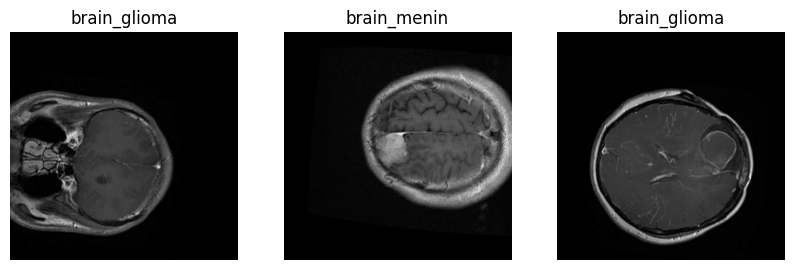

In [41]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)

## VGG16 model

In [55]:
vgg16_model=initiate_model_VGG16(num_classes,
                                 image_batch,class_name)

In [56]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [44]:
brain_vgg16_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                               model=vgg16_model,
                                                               learning_rate=0.0005)

In [45]:
brain_vgg16_model_fit=modelFit(brain_vgg16_model,
                               rlr,
                               checkpoint,
                               epochs=10,
                               batchSize = 32)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8670
Epoch 1: val_loss improved from inf to 0.21115, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 108s 324ms/step - loss: 0.3297 - accuracy: 0.8670 - val_loss: 0.2112 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9398
Epoch 2: val_loss improved from 0.21115 to 0.14899, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 105s 319ms/step - loss: 0.1637 - accuracy: 0.9398 - val_loss: 0.1490 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9523
Epoch 3: val_loss improved from 0.14899 to 0.12481, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 105s 319ms/step - loss: 0.1280 - accuracy: 0.9523 - val_loss: 0.1248 - val_accuracy: 0.9524 - lr: 0.0010
Epoch

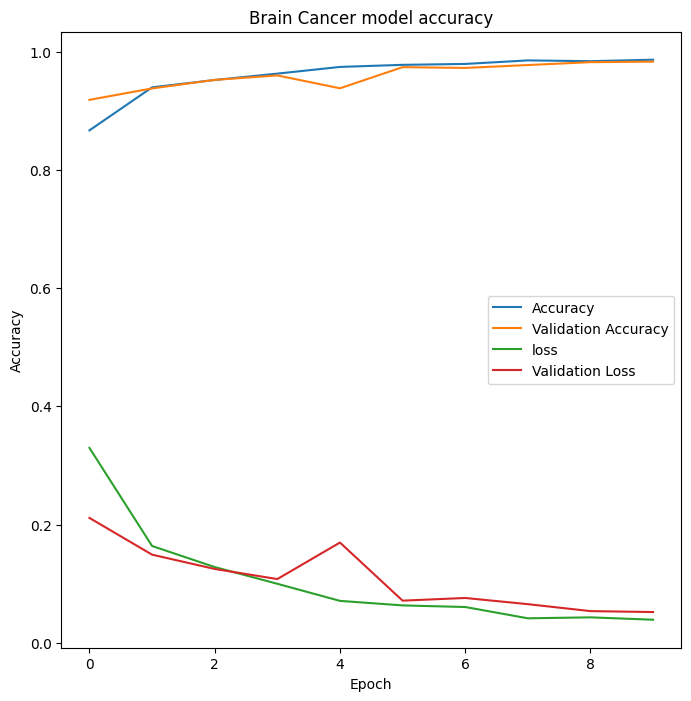

<Figure size 640x480 with 0 Axes>

In [46]:
plotOutput(hist=brain_vgg16_model_fit,
           className=class_name)

In [47]:
brain_vgg16_accuracy=evalModel(brain_vgg16_model)

141/141 [==============================] - 31s 221ms/step - loss: 0.0565 - accuracy: 0.9796
Accuracy on the Test Set = 97.96 %


In [48]:
saveModel(brain_vgg16_model,
          className=class_name)

Model Saved!


141/141 [==============================] - 32s 225ms/step


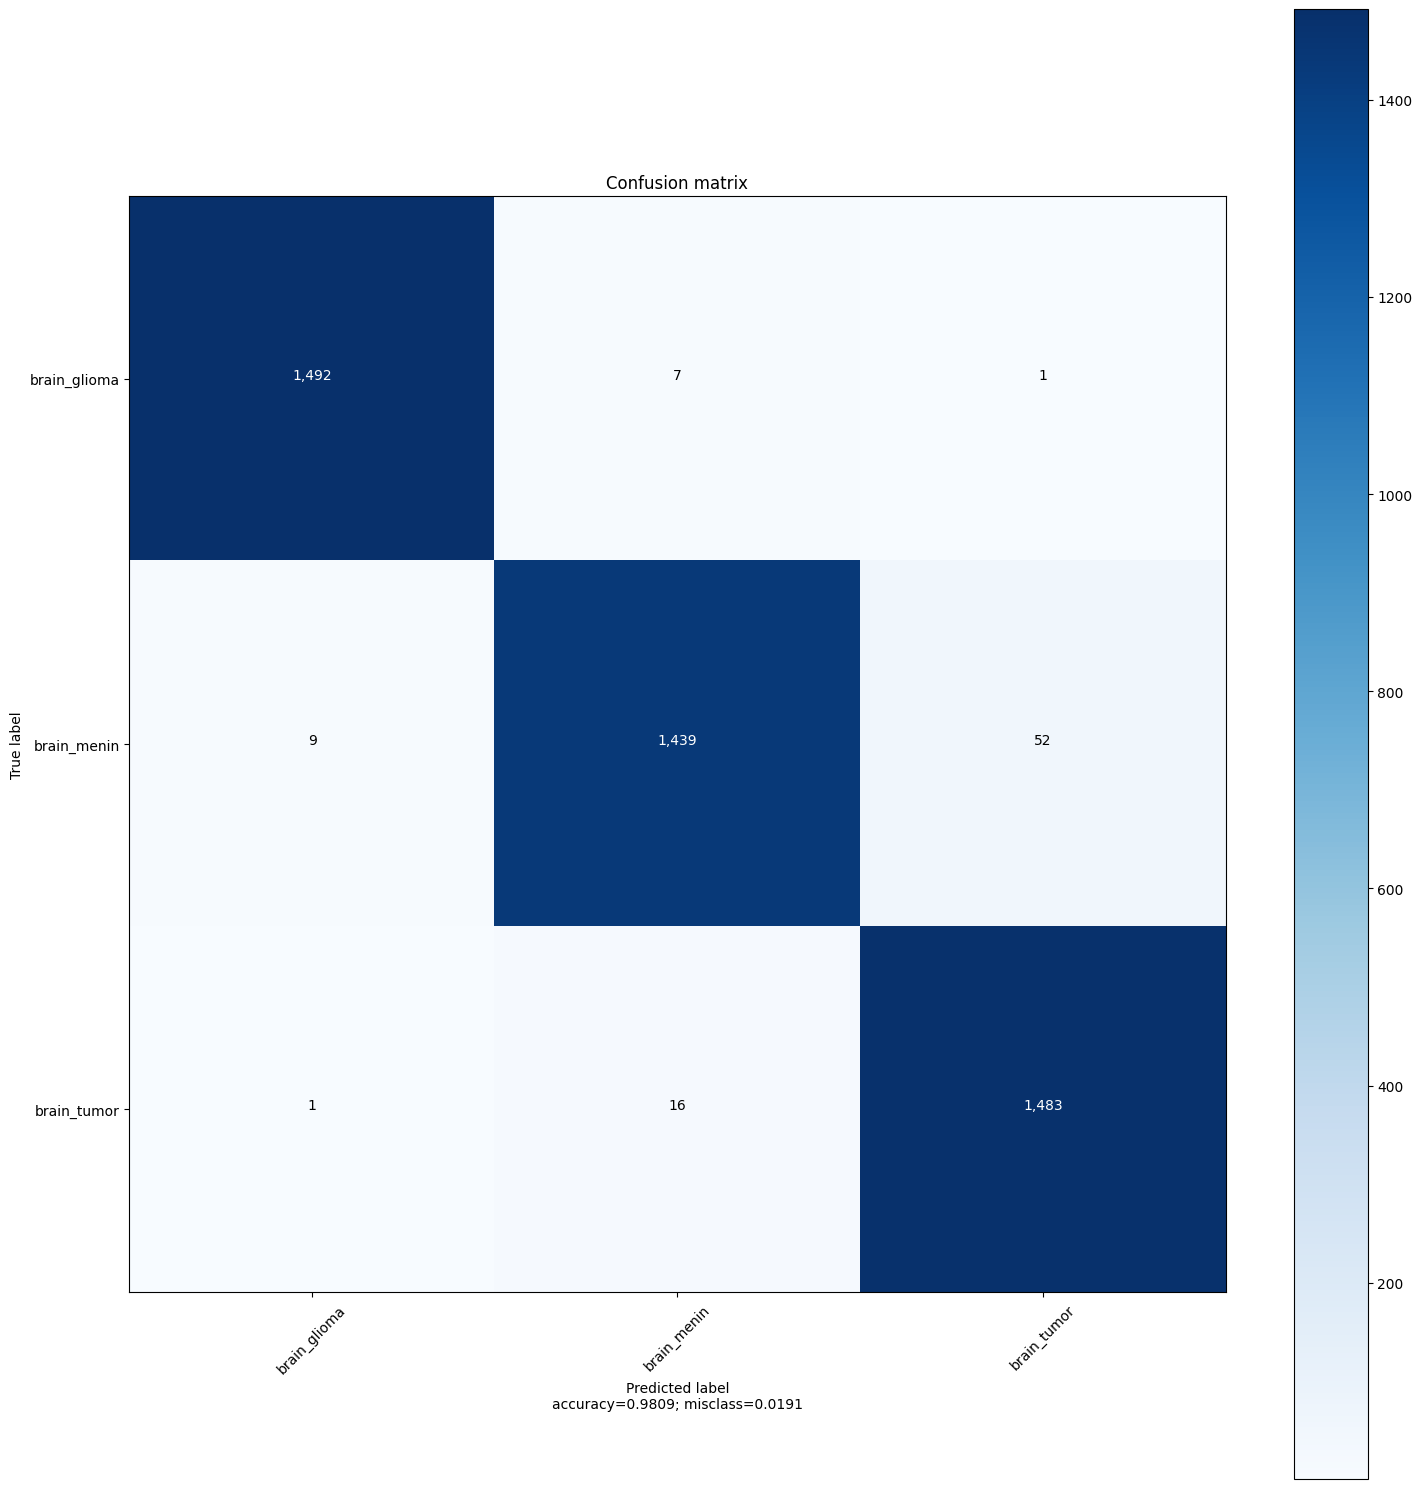

<Figure size 640x480 with 0 Axes>

In [49]:
plot_confusion_matrix(brain_vgg16_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)

## Resnet50

In [73]:
Resnet50_model=initiate_model_Resnet50(num_classes,
                                       image_batch,class_name)

In [74]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [83]:
brain_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                          model=Resnet50_model,
                                                                          learning_rate=0.001)

In [84]:
brain_renet50_model_fit=modelFit(brain_renet50_model,
                                 rlr,
                                 checkpoint,
                                 epochs=10,
                                 batchSize = 32)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.8870
Epoch 1: val_loss improved from inf to 0.31822, saving model to Brain CancerResnet50.h5
329/329 [==============================] - 113s 336ms/step - loss: 0.2870 - accuracy: 0.8870 - val_loss: 0.3182 - val_accuracy: 0.8729 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9044
Epoch 2: val_loss improved from 0.31822 to 0.23514, saving model to Brain CancerResnet50.h5
329/329 [==============================] - 111s 336ms/step - loss: 0.2466 - accuracy: 0.9044 - val_loss: 0.2351 - val_accuracy: 0.9098 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9121
Epoch 3: val_loss did not improve from 0.23514
329/329 [==============================] - 110s 335ms/step - loss: 0.2311 - accuracy: 0.9121 - val_loss: 0.2730 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 4/10
329/329 [=====================

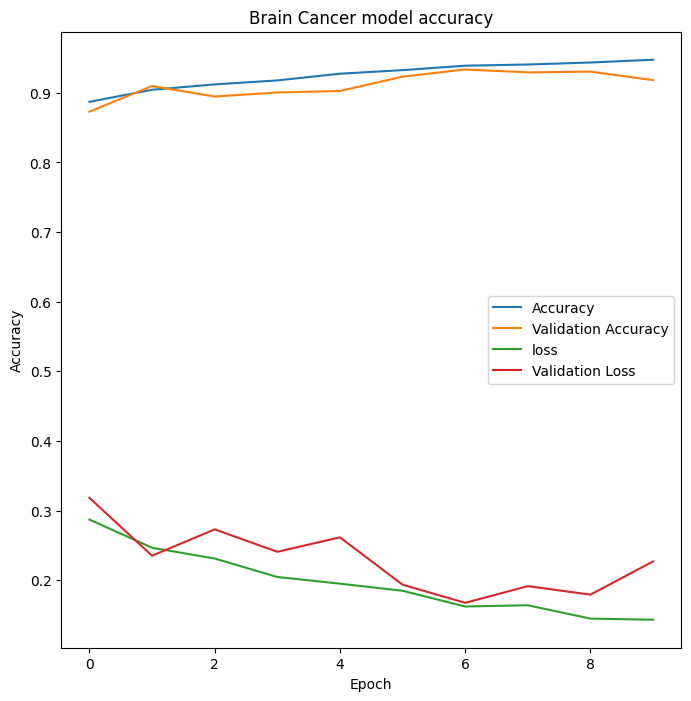

<Figure size 640x480 with 0 Axes>

In [85]:
plotOutput(hist=brain_renet50_model_fit,
           className=class_name)

In [86]:
brain_renet50_accuracy=evalModel(brain_renet50_model)

141/141 [==============================] - 33s 235ms/step - loss: 0.2306 - accuracy: 0.9171
Accuracy on the Test Set = 91.71 %


In [87]:
saveModel_Resnet50(brain_renet50_model,
                   className=class_name)

Model Saved!


141/141 [==============================] - 35s 240ms/step


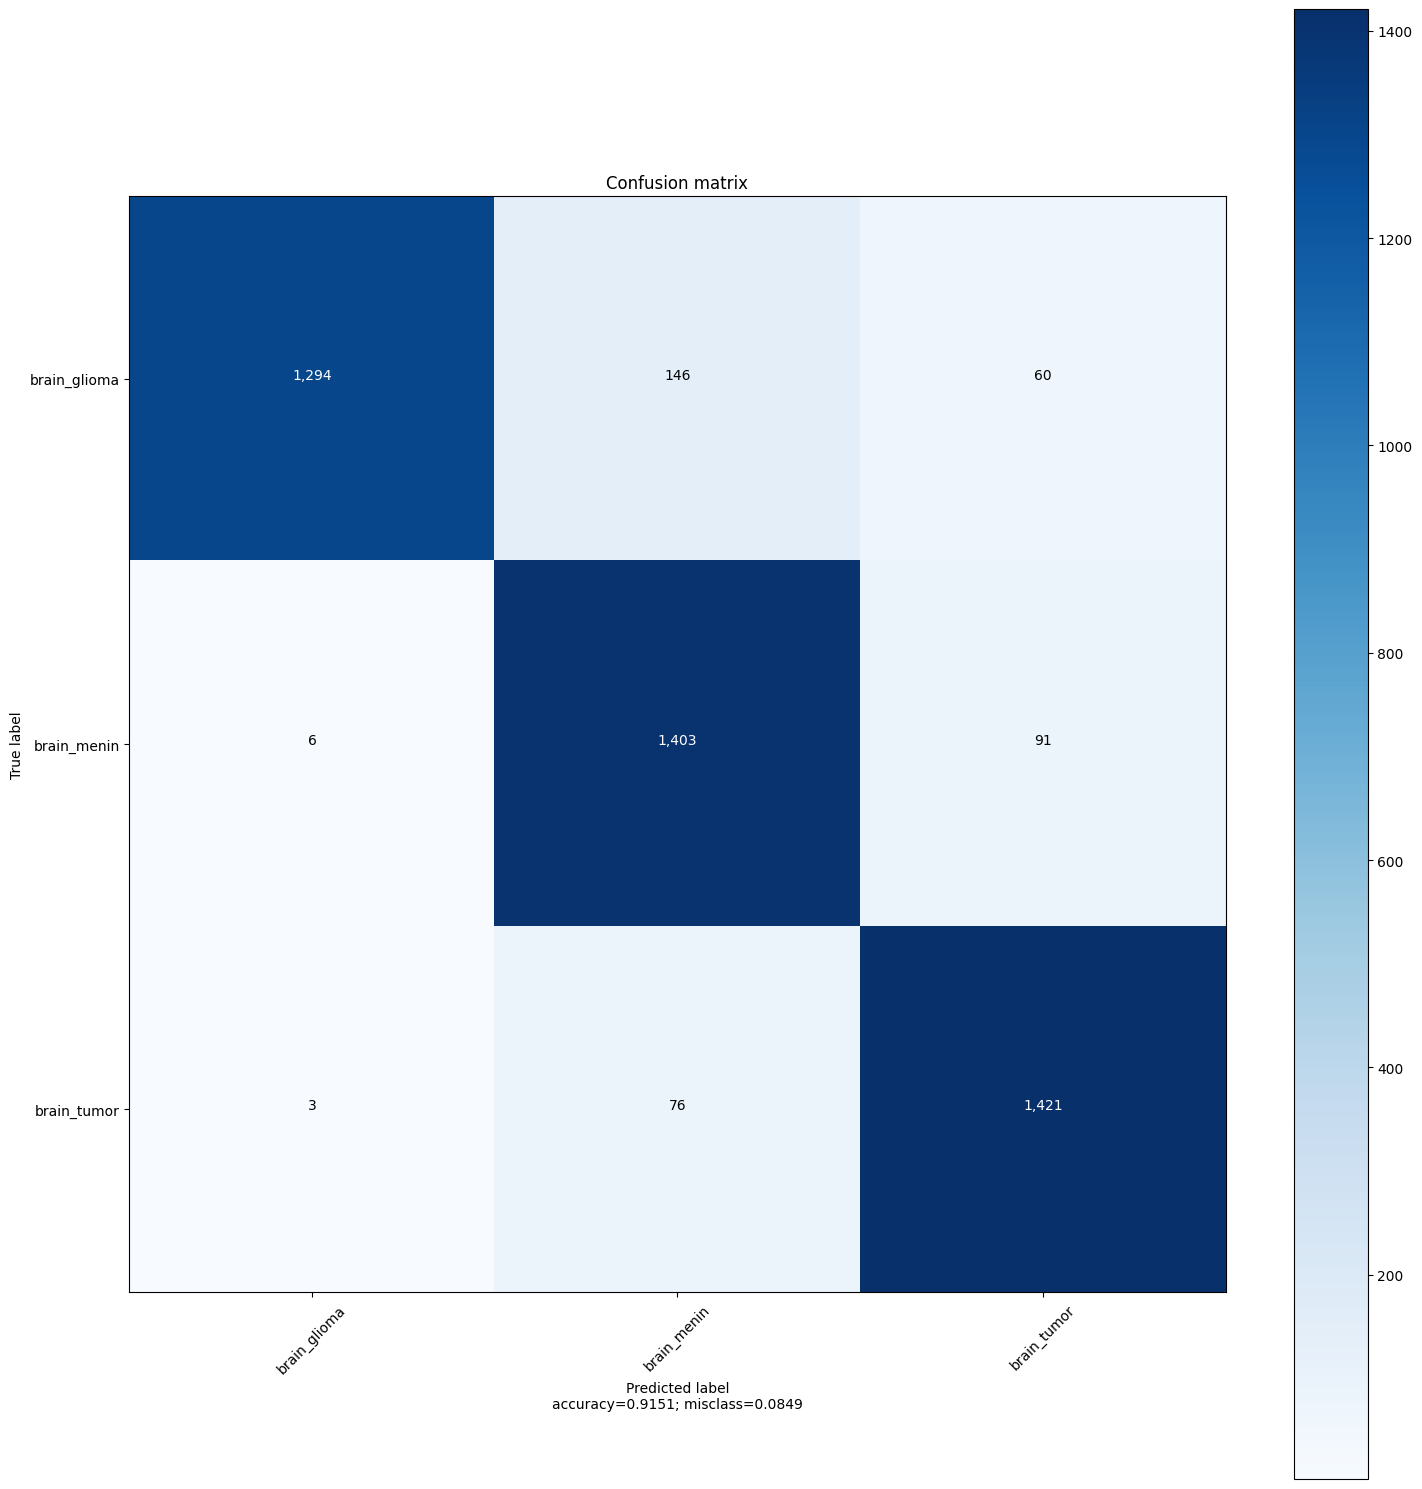

<Figure size 640x480 with 0 Axes>

In [88]:
plot_confusion_matrix(brain_renet50_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)




---



---


# **Breast Cancer**

In [89]:
class_name='Breast Cancer'


Total for trainning and validation :  Found 10000 files belonging to 2 classes.
['breast_benign', 'breast_malignant']

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.
(32, 512, 512, 3)
(32,)


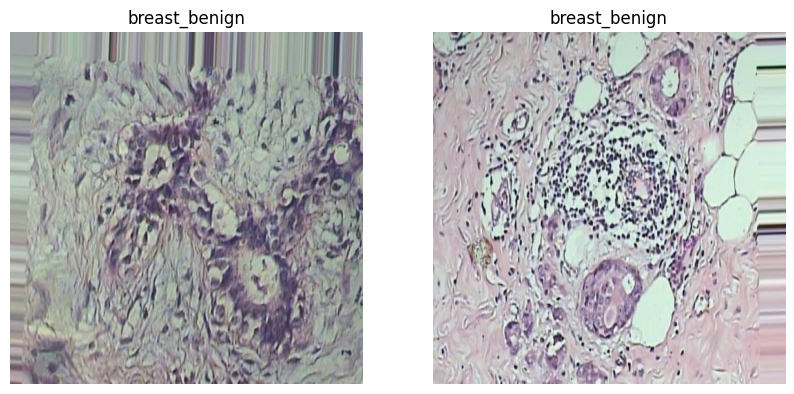

In [90]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)



## **VGG16**

In [91]:
vgg16_model=initiate_model_VGG16(num_classes,
                                 image_batch,class_name)

In [92]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [98]:
breast_vgg_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                              model=vgg16_model,
                                                              learning_rate=0.001)

In [99]:
breast_vgg_model_fit=modelFit(breast_vgg_model,
                              rlr,
                              checkpoint,
                              epochs=10,
                              batchSize = 32)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9003
Epoch 1: val_loss improved from inf to 0.20918, saving model to Breast CancerVGG16.h5
219/219 [==============================] - 95s 424ms/step - loss: 0.2467 - accuracy: 0.9003 - val_loss: 0.2092 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9073
Epoch 2: val_loss improved from 0.20918 to 0.18405, saving model to Breast CancerVGG16.h5
219/219 [==============================] - 89s 406ms/step - loss: 0.2247 - accuracy: 0.9073 - val_loss: 0.1841 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9277
Epoch 3: val_loss did not improve from 0.18405
219/219 [==============================] - 90s 410ms/step - loss: 0.1775 - accuracy: 0.9277 - val_loss: 0.1918 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 4/10
219/219 [============================

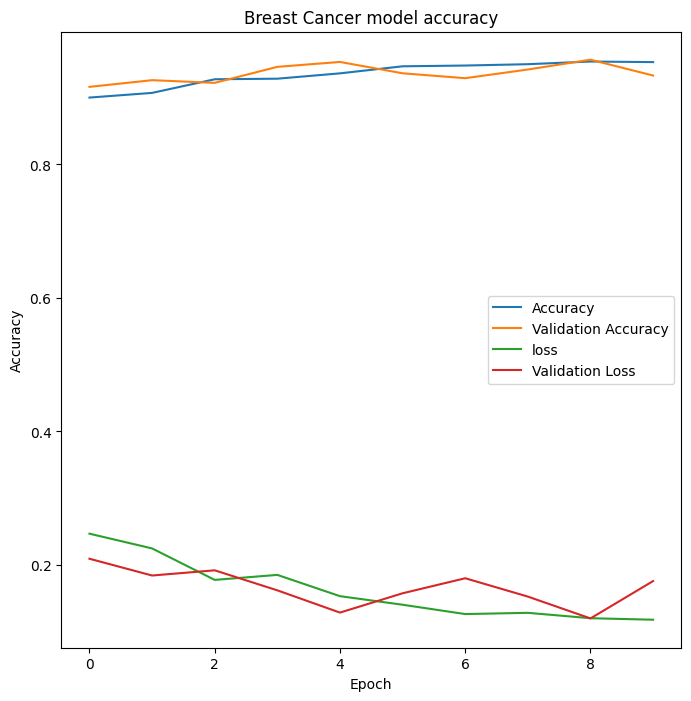

<Figure size 640x480 with 0 Axes>

In [100]:
plotOutput(hist=breast_vgg_model_fit,
           className=class_name)

In [101]:
breast_vgg_accuracy=evalModel(breast_vgg_model)

94/94 [==============================] - 28s 297ms/step - loss: 0.1744 - accuracy: 0.9317
Accuracy on the Test Set = 93.17 %


In [102]:
saveModel(breast_vgg_model,
          className=class_name)

Model Saved!


94/94 [==============================] - 28s 292ms/step


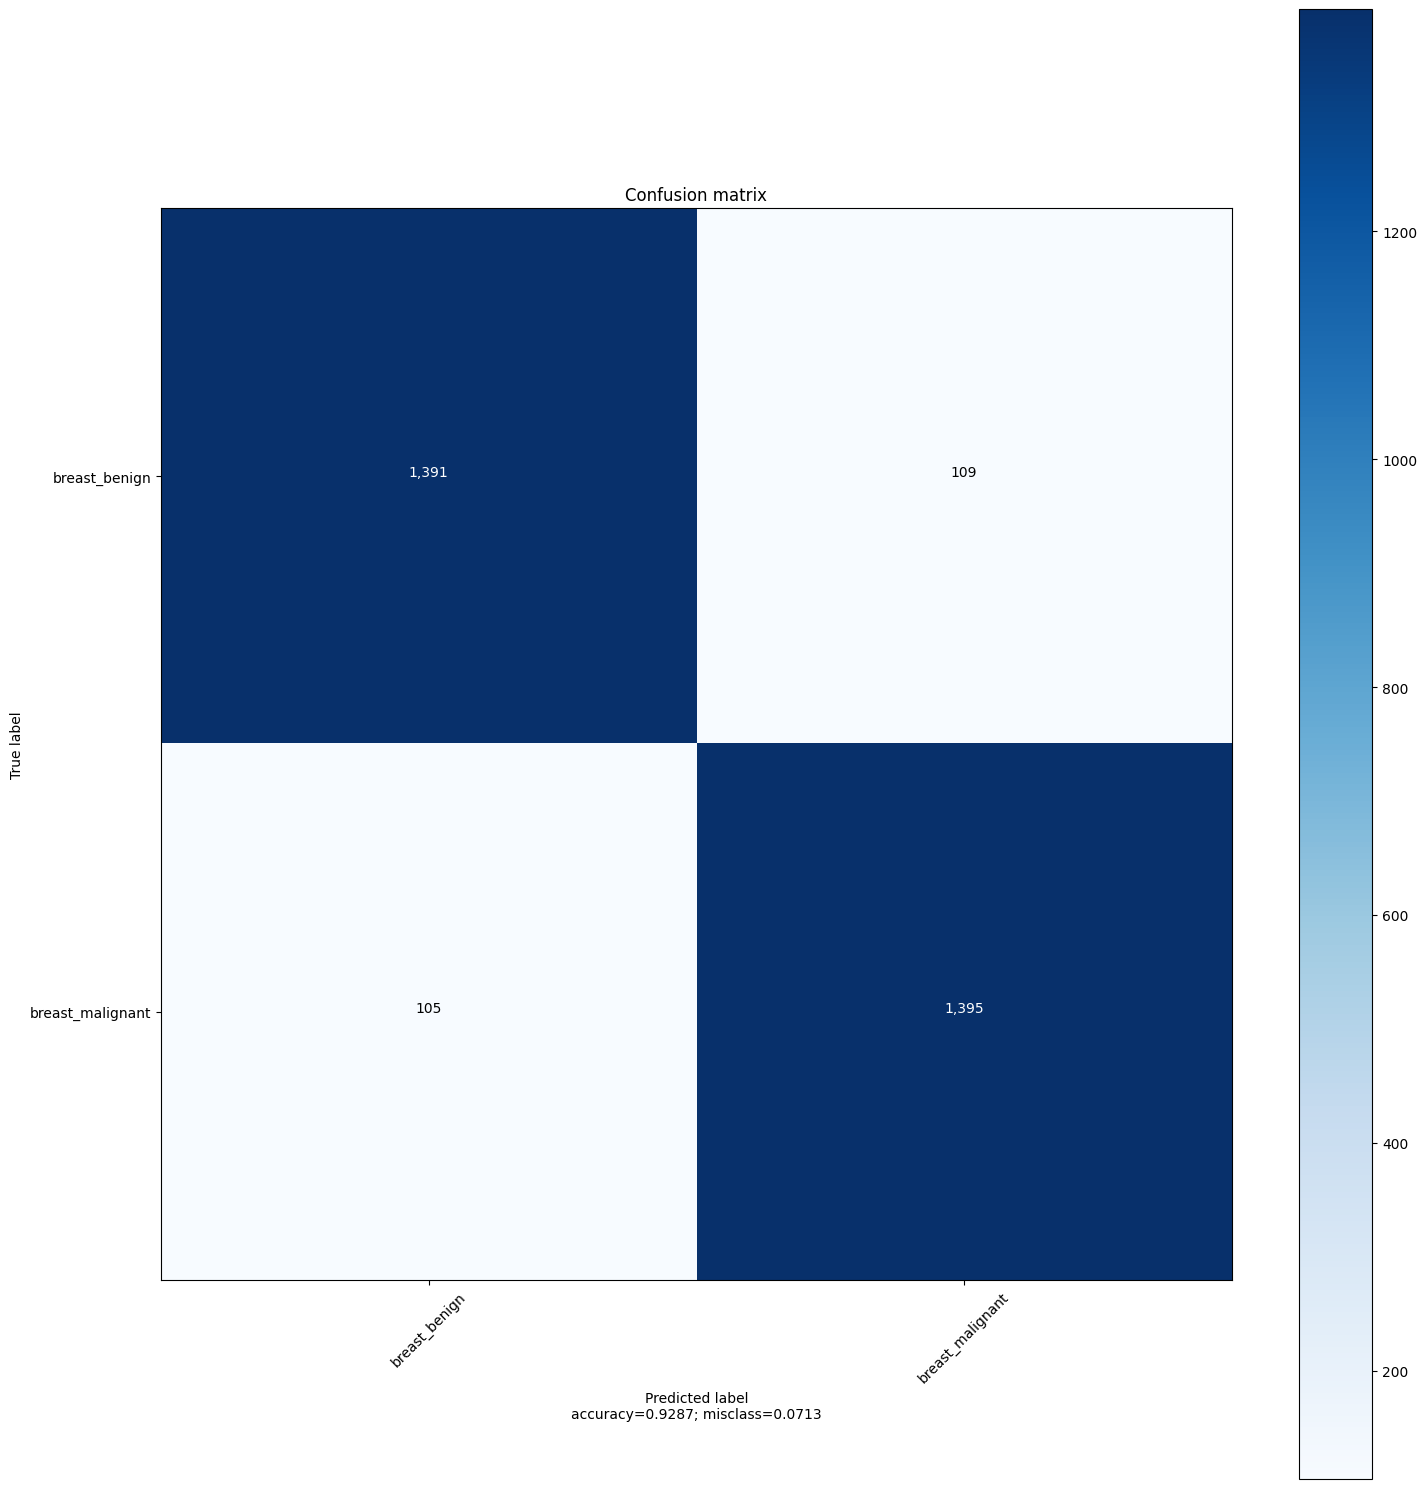

<Figure size 640x480 with 0 Axes>

In [103]:
plot_confusion_matrix(breast_vgg_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)

## Resnet50

In [104]:
Resnet50_model=initiate_model_Resnet50(num_classes,
                                       image_batch,class_name)

In [105]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [106]:
breast_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                           model=Resnet50_model,
                                                                           learning_rate=0.001)

In [107]:
breast_renet50_model_fit=modelFit(breast_renet50_model,
                                  rlr,
                                  checkpoint,
                                  epochs=10,
                                  batchSize = 32)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.7470
Epoch 1: val_loss improved from inf to 0.49003, saving model to Breast CancerResnet50.h5
219/219 [==============================] - 102s 449ms/step - loss: 0.5158 - accuracy: 0.7470 - val_loss: 0.4900 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.8070
Epoch 2: val_loss improved from 0.49003 to 0.45751, saving model to Breast CancerResnet50.h5
219/219 [==============================] - 93s 426ms/step - loss: 0.4203 - accuracy: 0.8070 - val_loss: 0.4575 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8290
Epoch 3: val_loss improved from 0.45751 to 0.45539, saving model to Breast CancerResnet50.h5
219/219 [==============================] - 95s 433ms/step - loss: 0.3906 - accuracy: 0.8290 - val_loss: 0.4554 - val_accuracy: 0.7777 - lr: 0.

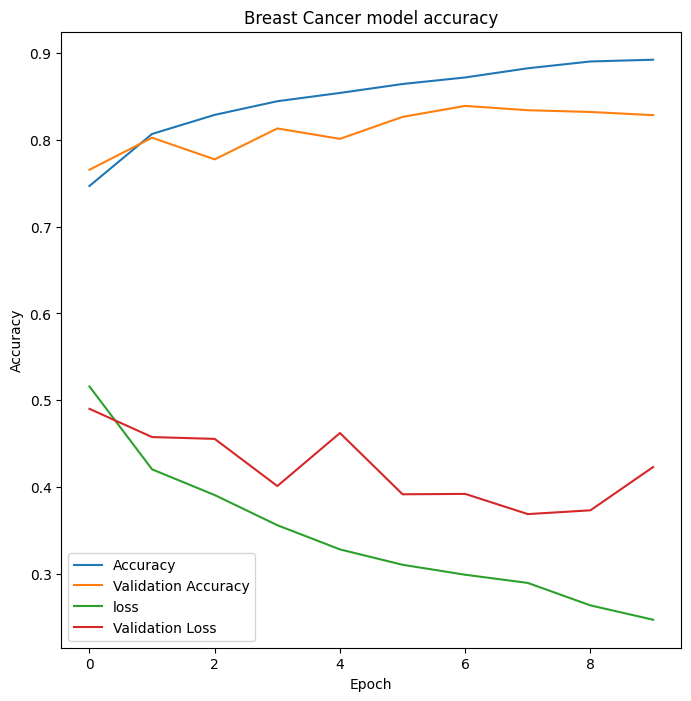

<Figure size 640x480 with 0 Axes>

In [108]:
plotOutput(hist=breast_renet50_model_fit,
           className=class_name)

In [110]:
breast_renet50_accuracy=evalModel(breast_renet50_model)

94/94 [==============================] - 28s 288ms/step - loss: 0.4231 - accuracy: 0.8393
Accuracy on the Test Set = 83.93 %


In [111]:
saveModel_Resnet50(breast_renet50_model,
                   className=class_name)

Model Saved!


94/94 [==============================] - 27s 278ms/step


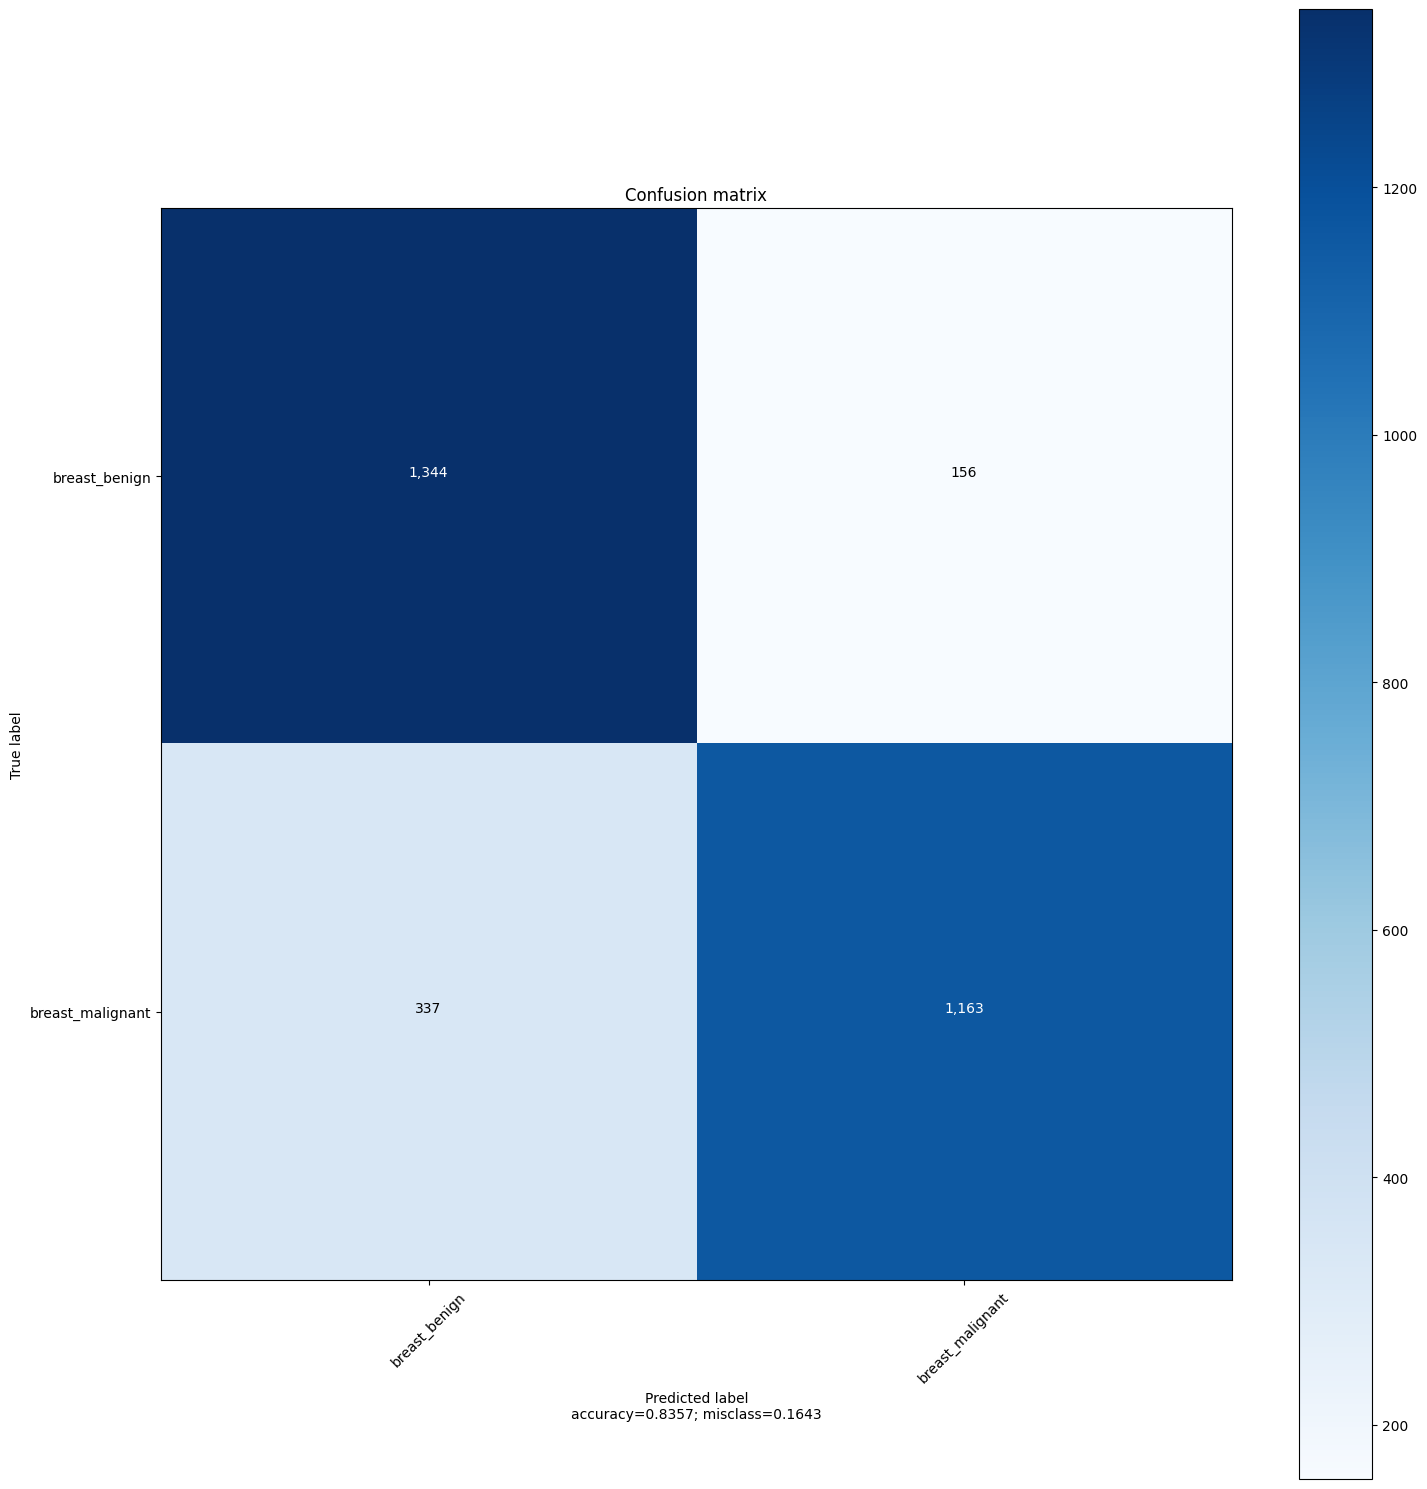

<Figure size 640x480 with 0 Axes>

In [112]:
plot_confusion_matrix(breast_renet50_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)




---


---
# **Cervical Cancer**


In [113]:
class_name='Cervical Cancer'


Total for trainning and validation :  Found 25000 files belonging to 5 classes.
['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.
(32, 512, 512, 3)
(32,)


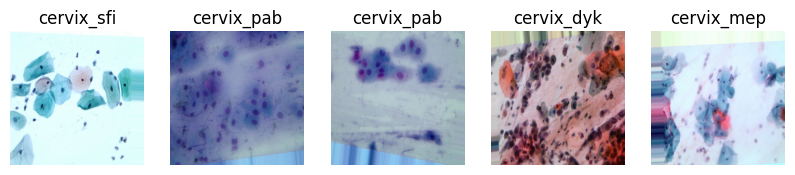

In [114]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)



## **VGG16**

In [115]:
vgg16_model=initiate_model_VGG16(num_classes,
                                 image_batch,class_name)

In [116]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [117]:
Cervical_vgg_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                                model=vgg16_model,
                                                                learning_rate=0.001)

In [118]:
Cervical_vgg_model_fit=modelFit(Cervical_vgg_model,
                                rlr,
                                checkpoint,
                                epochs=10,
                                batchSize = 32)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8683
Epoch 1: val_loss improved from inf to 0.10585, saving model to Cervical CancerVGG16.h5
547/547 [==============================] - 209s 378ms/step - loss: 0.3525 - accuracy: 0.8683 - val_loss: 0.1059 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9731
Epoch 2: val_loss improved from 0.10585 to 0.04388, saving model to Cervical CancerVGG16.h5
547/547 [==============================] - 185s 338ms/step - loss: 0.0782 - accuracy: 0.9731 - val_loss: 0.0439 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9827
Epoch 3: val_loss improved from 0.04388 to 0.02638, saving model to Cervical CancerVGG16.h5
547/547 [==============================] - 185s 337ms/step - loss: 0.0477 - accuracy: 0.9827 - val_loss: 0.0264 - val_accuracy: 0.9909 - lr: 0.0

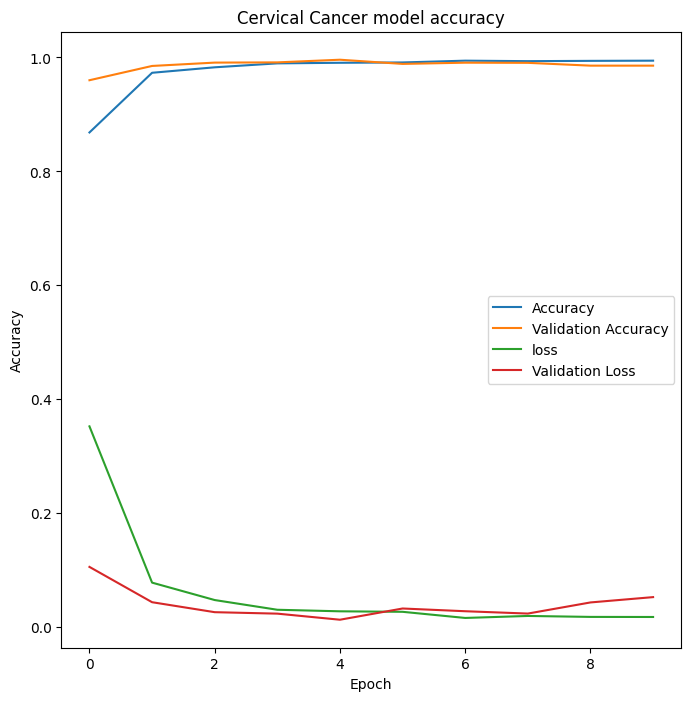

<Figure size 640x480 with 0 Axes>

In [119]:
plotOutput(hist=Cervical_vgg_model_fit,
           className=class_name)

In [120]:
Cervical_vgg_accuracy=evalModel(Cervical_vgg_model)

235/235 [==============================] - 57s 244ms/step - loss: 0.0576 - accuracy: 0.9833
Accuracy on the Test Set = 98.33 %


In [121]:
saveModel(Cervical_vgg_model,
          className=class_name)

Model Saved!


235/235 [==============================] - 57s 240ms/step


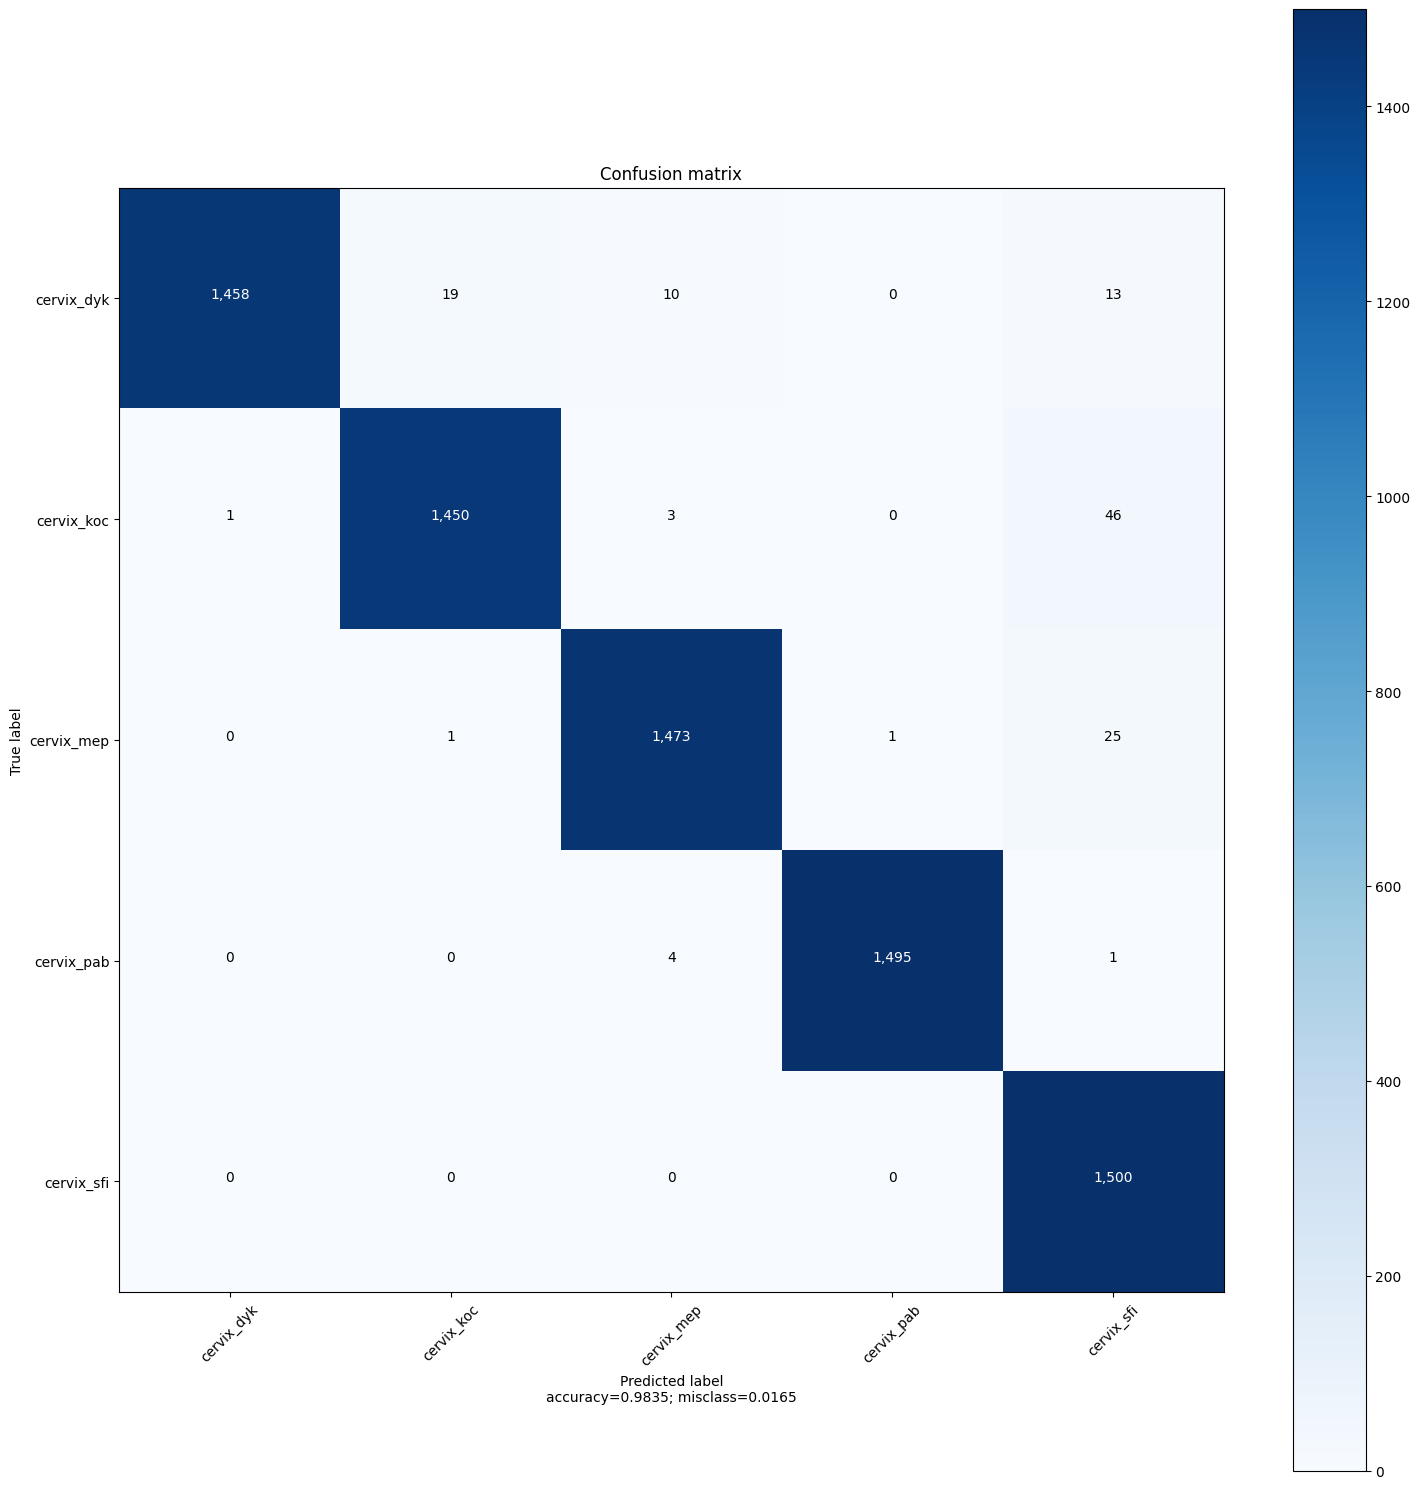

<Figure size 640x480 with 0 Axes>

In [122]:
plot_confusion_matrix(Cervical_vgg_model,
                      className=class_name, 
                      classes=class_names,
                      normalize=False)

## Resnet50

In [123]:
Resnet50_model=initiate_model_Resnet50(num_classes,
                                       image_batch,class_name)

In [124]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [125]:
Cervical_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                             model=Resnet50_model,
                                                                             learning_rate=0.001)

In [126]:
Cervical_renet50_model_fit=modelFit(Cervical_renet50_model,
                                    rlr,
                                    checkpoint,
                                    epochs=10, 
                                    batchSize = 32)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7393
Epoch 1: val_loss improved from inf to 0.35036, saving model to Cervical CancerResnet50.h5
547/547 [==============================] - 196s 351ms/step - loss: 0.6739 - accuracy: 0.7393 - val_loss: 0.3504 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8815
Epoch 2: val_loss improved from 0.35036 to 0.26790, saving model to Cervical CancerResnet50.h5
547/547 [==============================] - 192s 351ms/step - loss: 0.3227 - accuracy: 0.8815 - val_loss: 0.2679 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9170
Epoch 3: val_loss improved from 0.26790 to 0.25090, saving model to Cervical CancerResnet50.h5
547/547 [==============================] - 189s 346ms/step - loss: 0.2359 - accuracy: 0.9170 - val_loss: 0.2509 - val_accuracy: 0.9103 

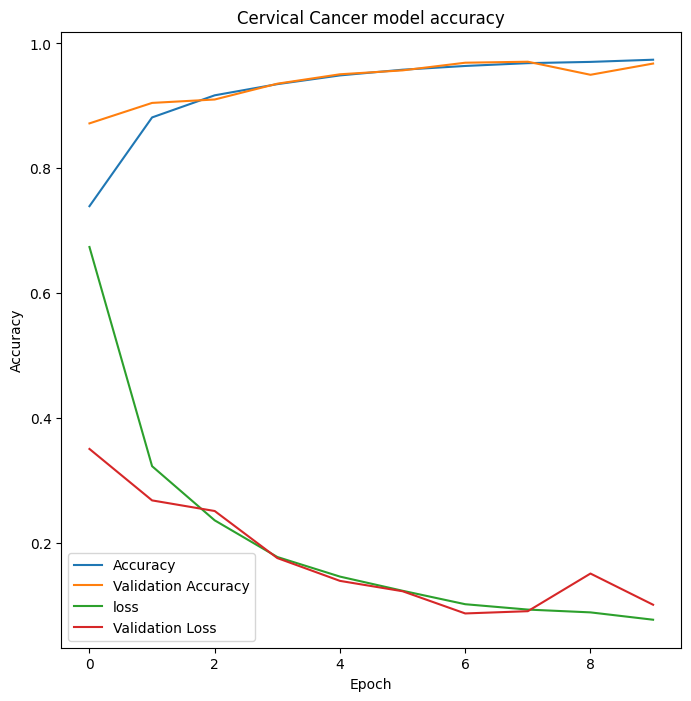

<Figure size 640x480 with 0 Axes>

In [127]:
plotOutput(hist=Cervical_renet50_model_fit,
           className=class_name)

In [128]:
Cervical_renet50_accuracy=evalModel(Cervical_renet50_model)

235/235 [==============================] - 62s 264ms/step - loss: 0.0979 - accuracy: 0.9701
Accuracy on the Test Set = 97.01 %


In [129]:
saveModel_Resnet50(Cervical_renet50_model,
                   className=class_name)

Model Saved!


235/235 [==============================] - 60s 252ms/step


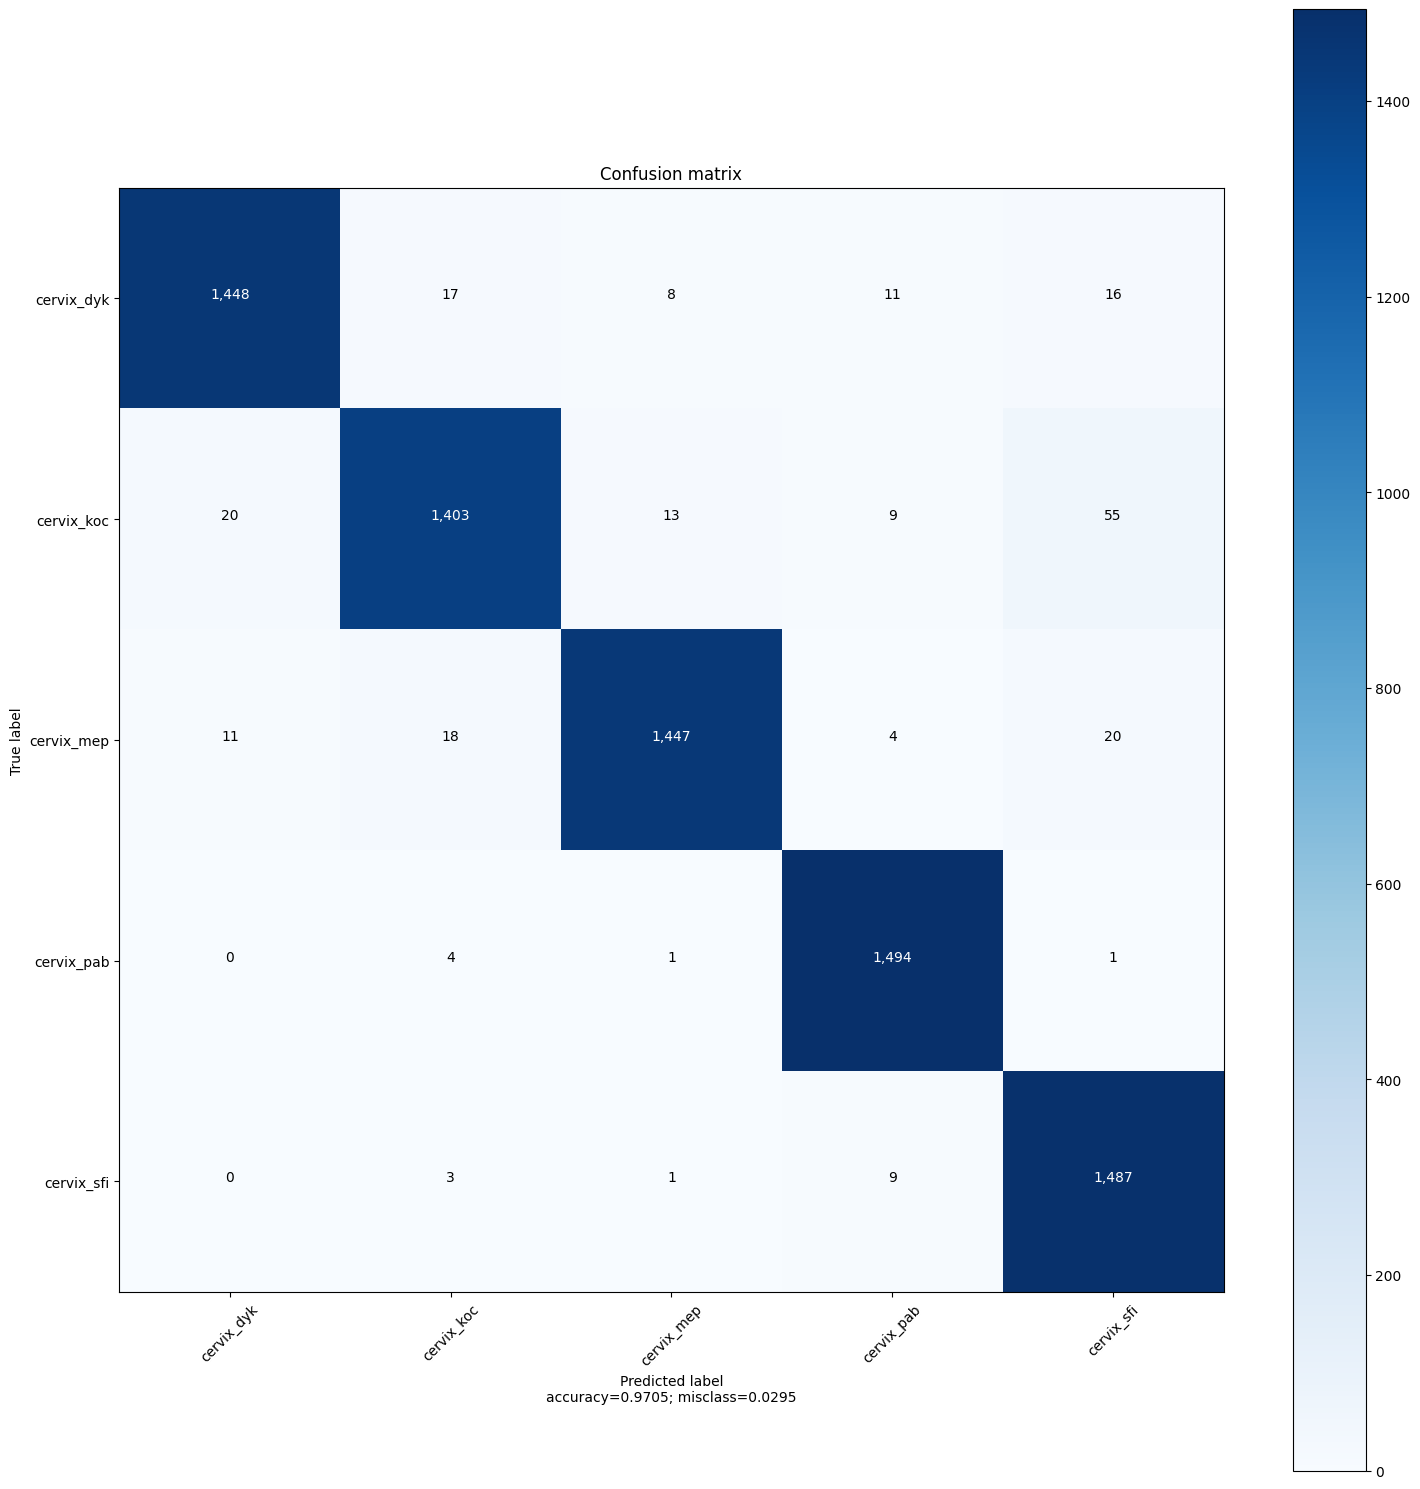

<Figure size 640x480 with 0 Axes>

In [130]:
plot_confusion_matrix(Cervical_renet50_model, 
                      className=class_name, 
                      classes=class_names,
                      normalize=False)




---



---


# **Kidney Cancer**

In [131]:
class_name='Kidney Cancer'


Total for trainning and validation :  Found 10000 files belonging to 2 classes.
['kidney_normal', 'kidney_tumor']

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.
(32, 512, 512, 3)
(32,)


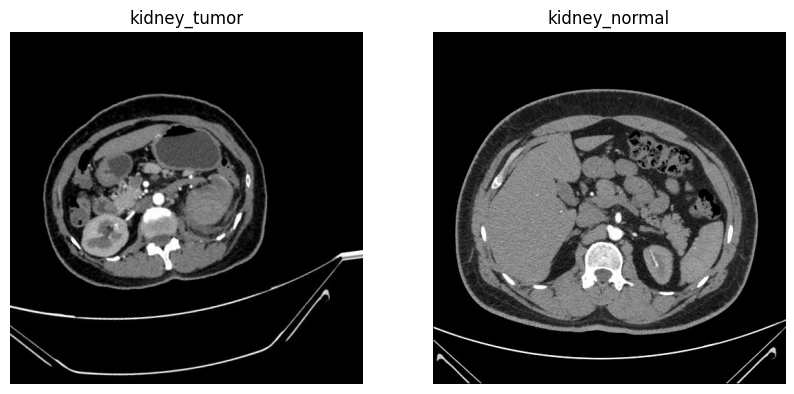

In [132]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)

## **VGG16**

In [133]:
vgg16_model=initiate_model_VGG16(num_classes,
                                 image_batch,class_name)

In [134]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [137]:
Kidney_vgg_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                              model=vgg16_model,
                                                              learning_rate=0.001)

In [138]:
Kidney_vgg_model_fit=modelFit(Kidney_vgg_model,
                              rlr,
                              checkpoint,
                              epochs=10,
                              batchSize = 32)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9974
Epoch 1: val_loss improved from inf to 0.79525, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 75s 334ms/step - loss: 0.0067 - accuracy: 0.9974 - val_loss: 0.7953 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9984
Epoch 2: val_loss improved from 0.79525 to 0.51854, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 72s 328ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.5185 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9983
Epoch 3: val_loss improved from 0.51854 to 0.11837, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 71s 326ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.1184 - val_accuracy: 0.9713 - lr: 0.0010
Epoch

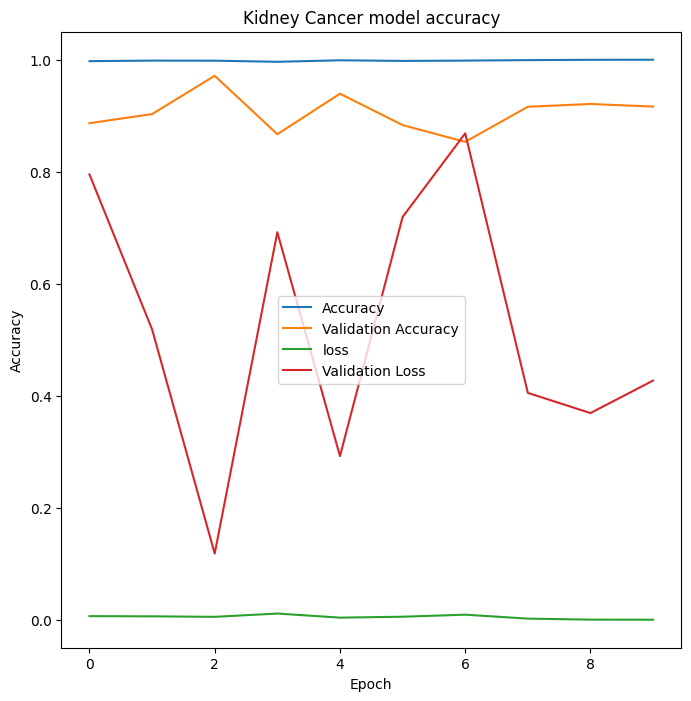

<Figure size 640x480 with 0 Axes>

In [139]:
plotOutput(hist=Kidney_vgg_model_fit,
           className=class_name)

In [140]:
Kidney_vgg_accuracy=evalModel(Kidney_vgg_model)

94/94 [==============================] - 21s 227ms/step - loss: 0.4263 - accuracy: 0.9153
Accuracy on the Test Set = 91.53 %


In [141]:
saveModel(Kidney_vgg_model,
          className=class_name)

Model Saved!


94/94 [==============================] - 21s 225ms/step


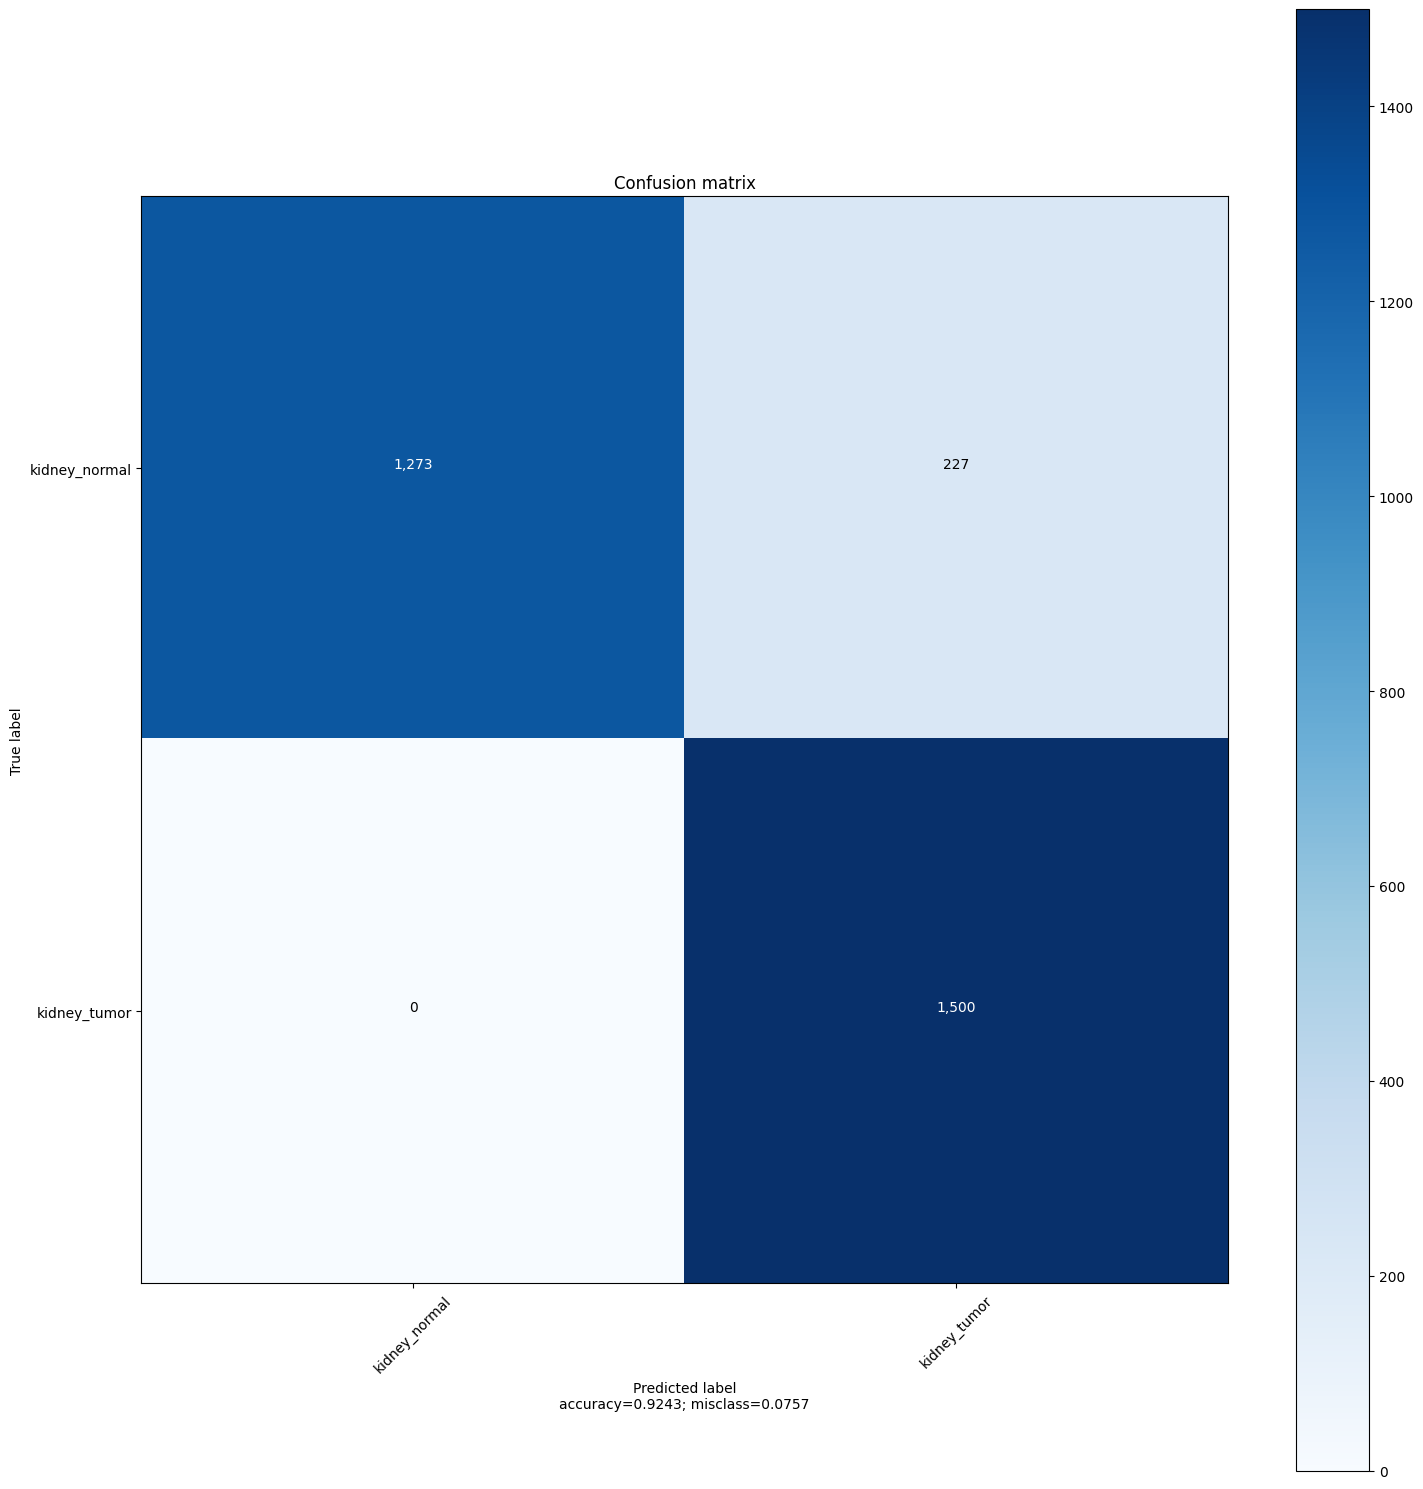

<Figure size 640x480 with 0 Axes>

In [142]:
plot_confusion_matrix(Kidney_vgg_model,
                      className=class_name,
                      classes=class_names, 
                      normalize=False)

## Resnet50

In [143]:
Resnet50_model=initiate_model_Resnet50(num_classes,image_batch,class_name)

In [144]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [145]:
Kidney_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                           model=Resnet50_model,
                                                                           learning_rate=0.001)

In [146]:
Kidney_renet50_model_fit=modelFit(Kidney_renet50_model,
                                  rlr,
                                  checkpoint,
                                  epochs=10, 
                                  batchSize = 32)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9094
Epoch 1: val_loss improved from inf to 0.91348, saving model to Kidney CancerResnet50.h5
219/219 [==============================] - 76s 331ms/step - loss: 0.2165 - accuracy: 0.9094 - val_loss: 0.9135 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9699
Epoch 2: val_loss improved from 0.91348 to 0.23844, saving model to Kidney CancerResnet50.h5
219/219 [==============================] - 75s 341ms/step - loss: 0.0838 - accuracy: 0.9699 - val_loss: 0.2384 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9703
Epoch 3: val_loss did not improve from 0.23844
219/219 [==============================] - 72s 328ms/step - loss: 0.0765 - accuracy: 0.9703 - val_loss: 0.3083 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 4/10
219/219 [======================

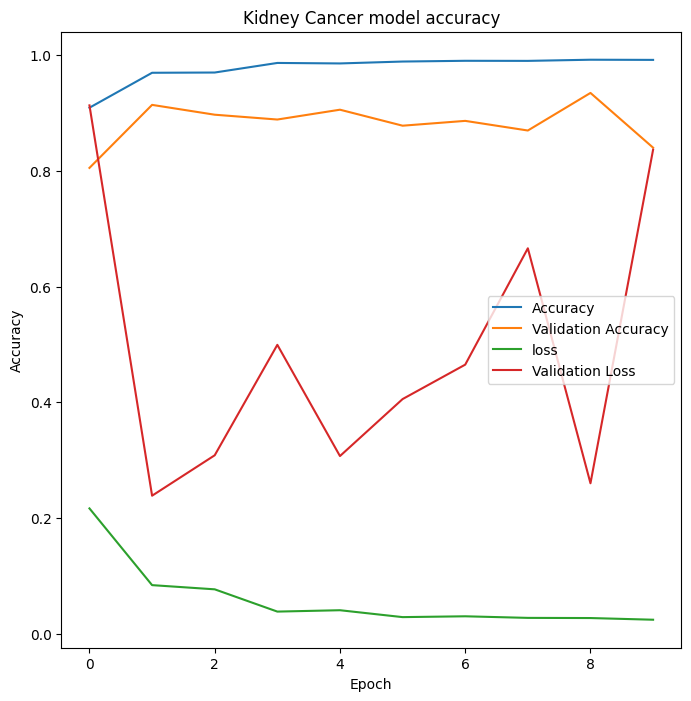

<Figure size 640x480 with 0 Axes>

In [147]:
plotOutput(hist=Kidney_renet50_model_fit,
           className=class_name)

In [148]:
Kidney_renet50_accuracy=evalModel(Kidney_renet50_model)

94/94 [==============================] - 22s 229ms/step - loss: 0.7798 - accuracy: 0.8490
Accuracy on the Test Set = 84.90 %


In [149]:
saveModel_Resnet50(Kidney_renet50_model,
                   className=class_name)

Model Saved!


94/94 [==============================] - 23s 241ms/step


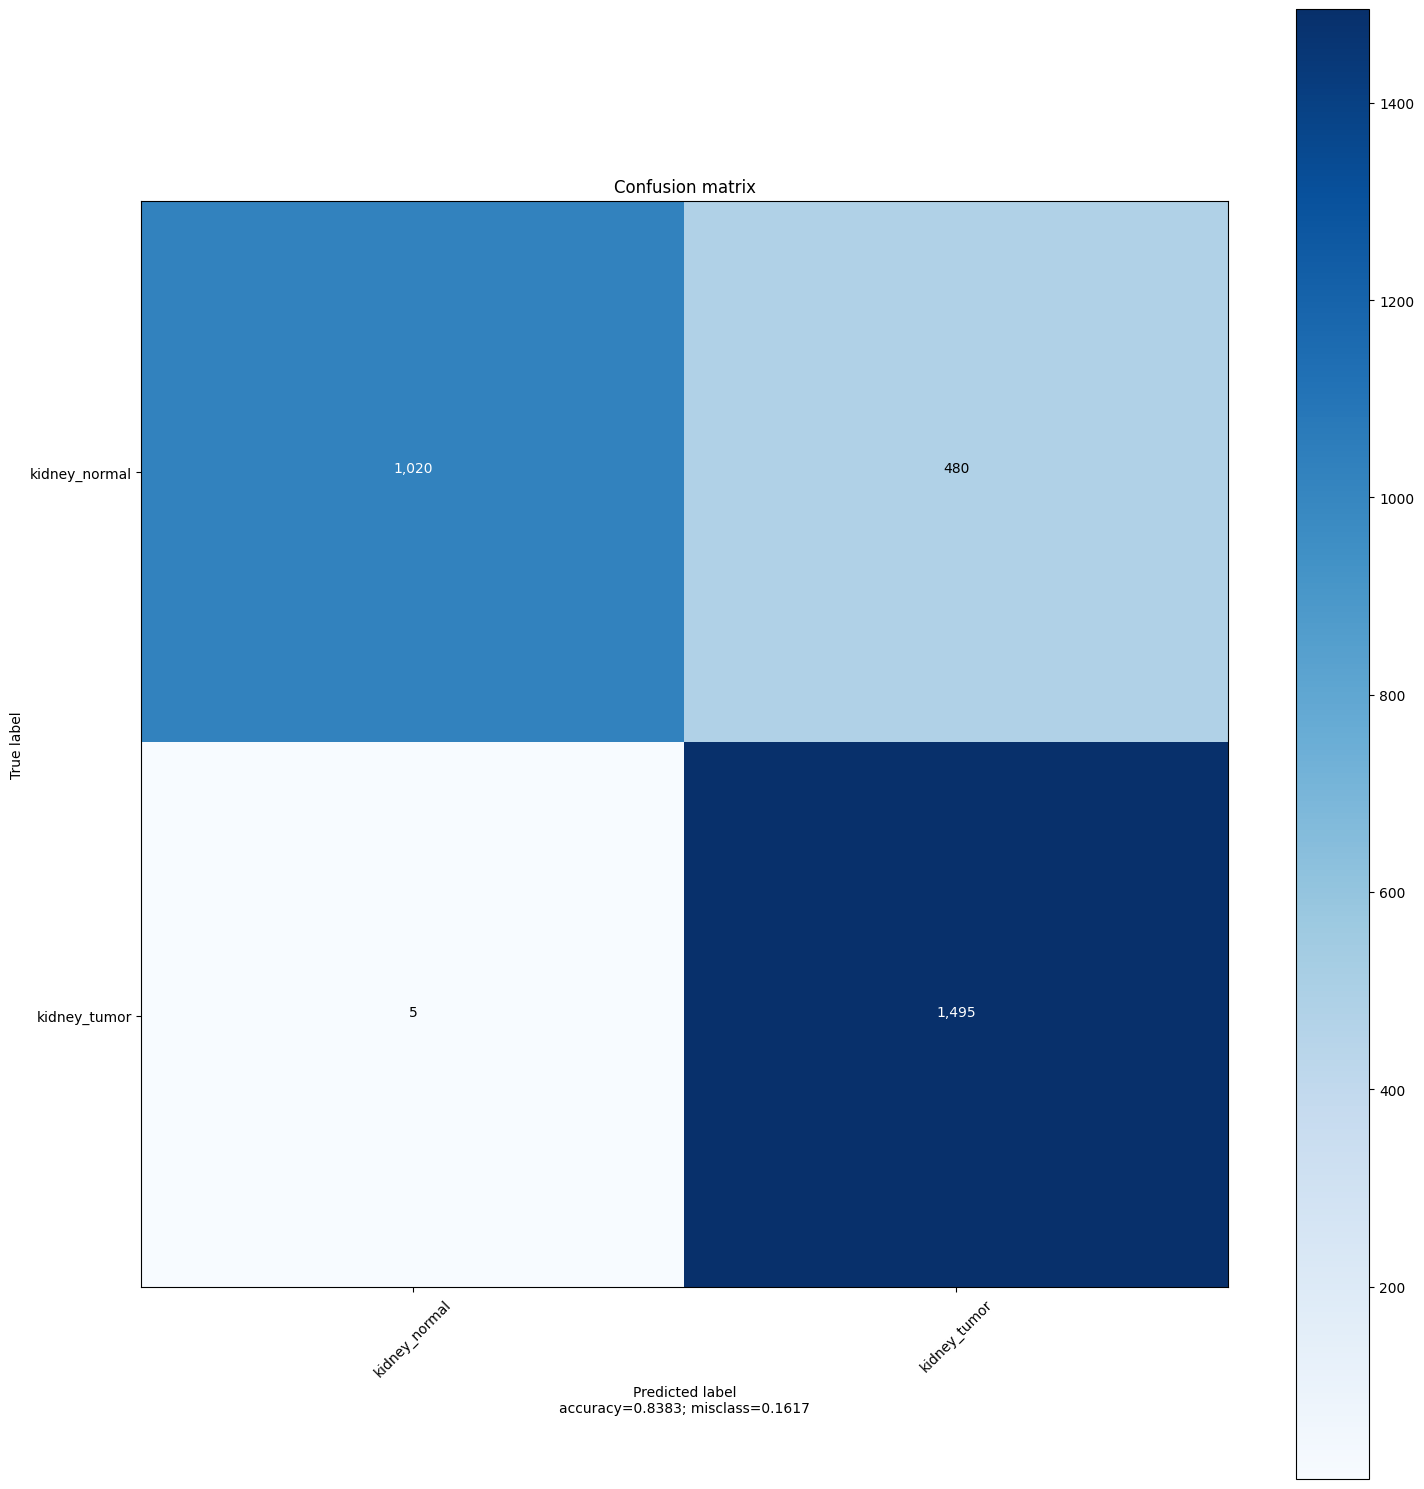

<Figure size 640x480 with 0 Axes>

In [150]:
plot_confusion_matrix(Kidney_renet50_model,
                      className=class_name,
                      classes=class_names, 
                      normalize=False)



---


---


# **Lung and Colon Cancer**

In [151]:
class_name='Lung and Colon Cancer'


Total for trainning and validation :  Found 25000 files belonging to 5 classes.
['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.
(32, 512, 512, 3)
(32,)


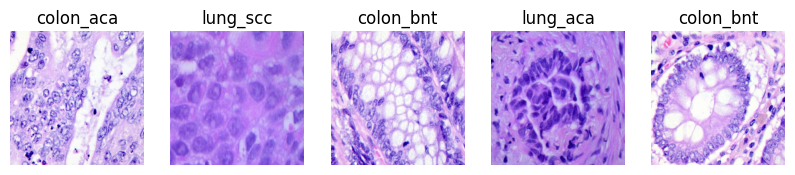

In [152]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)

## **VGG16**

In [153]:
vgg16_model=initiate_model_VGG16(num_classes,
                                 image_batch,class_name)

In [154]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [155]:
Lung_and_Colon_vgg_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                                      model=vgg16_model,
                                                                      learning_rate=0.001)

In [156]:
Lung_and_Colon_vgg_model_fit=modelFit(Lung_and_Colon_vgg_model,
                                      rlr,
                                      checkpoint,
                                      epochs=10,
                                      batchSize = 32)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9170
Epoch 1: val_loss improved from inf to 0.11767, saving model to Lung and Colon CancerVGG16.h5
547/547 [==============================] - 203s 369ms/step - loss: 0.2174 - accuracy: 0.9170 - val_loss: 0.1177 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9659
Epoch 2: val_loss improved from 0.11767 to 0.08157, saving model to Lung and Colon CancerVGG16.h5
547/547 [==============================] - 202s 370ms/step - loss: 0.0949 - accuracy: 0.9659 - val_loss: 0.0816 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9721
Epoch 3: val_loss improved from 0.08157 to 0.05344, saving model to Lung and Colon CancerVGG16.h5
547/547 [==============================] - 203s 371ms/step - loss: 0.0731 - accuracy: 0.9721 - val_loss: 0.0534 - val_accuracy

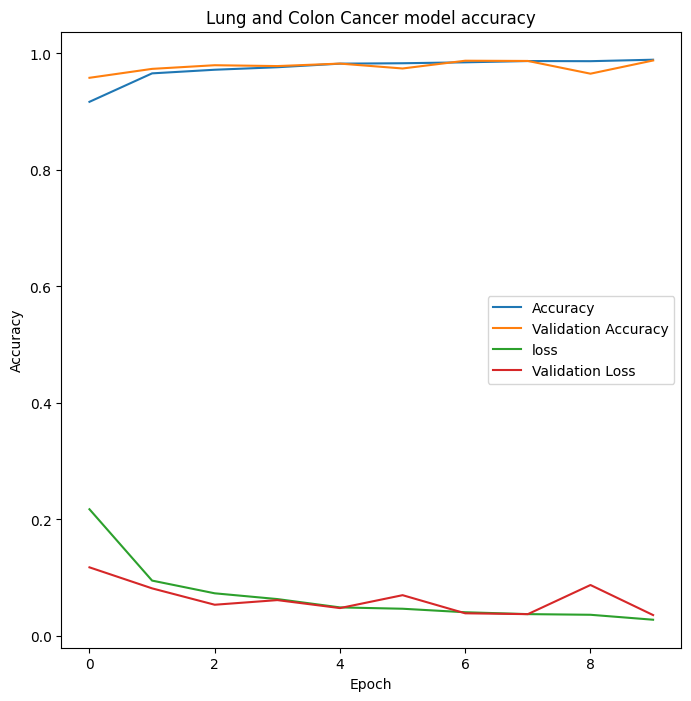

<Figure size 640x480 with 0 Axes>

In [157]:
plotOutput(hist=Lung_and_Colon_vgg_model_fit,
           className=class_name)

In [158]:
Lung_and_Colon_vgg_accuracy=evalModel(Lung_and_Colon_vgg_model)

235/235 [==============================] - 58s 245ms/step - loss: 0.0331 - accuracy: 0.9879
Accuracy on the Test Set = 98.79 %


In [159]:
saveModel(Lung_and_Colon_vgg_model, className=class_name)

Model Saved!


235/235 [==============================] - 57s 242ms/step


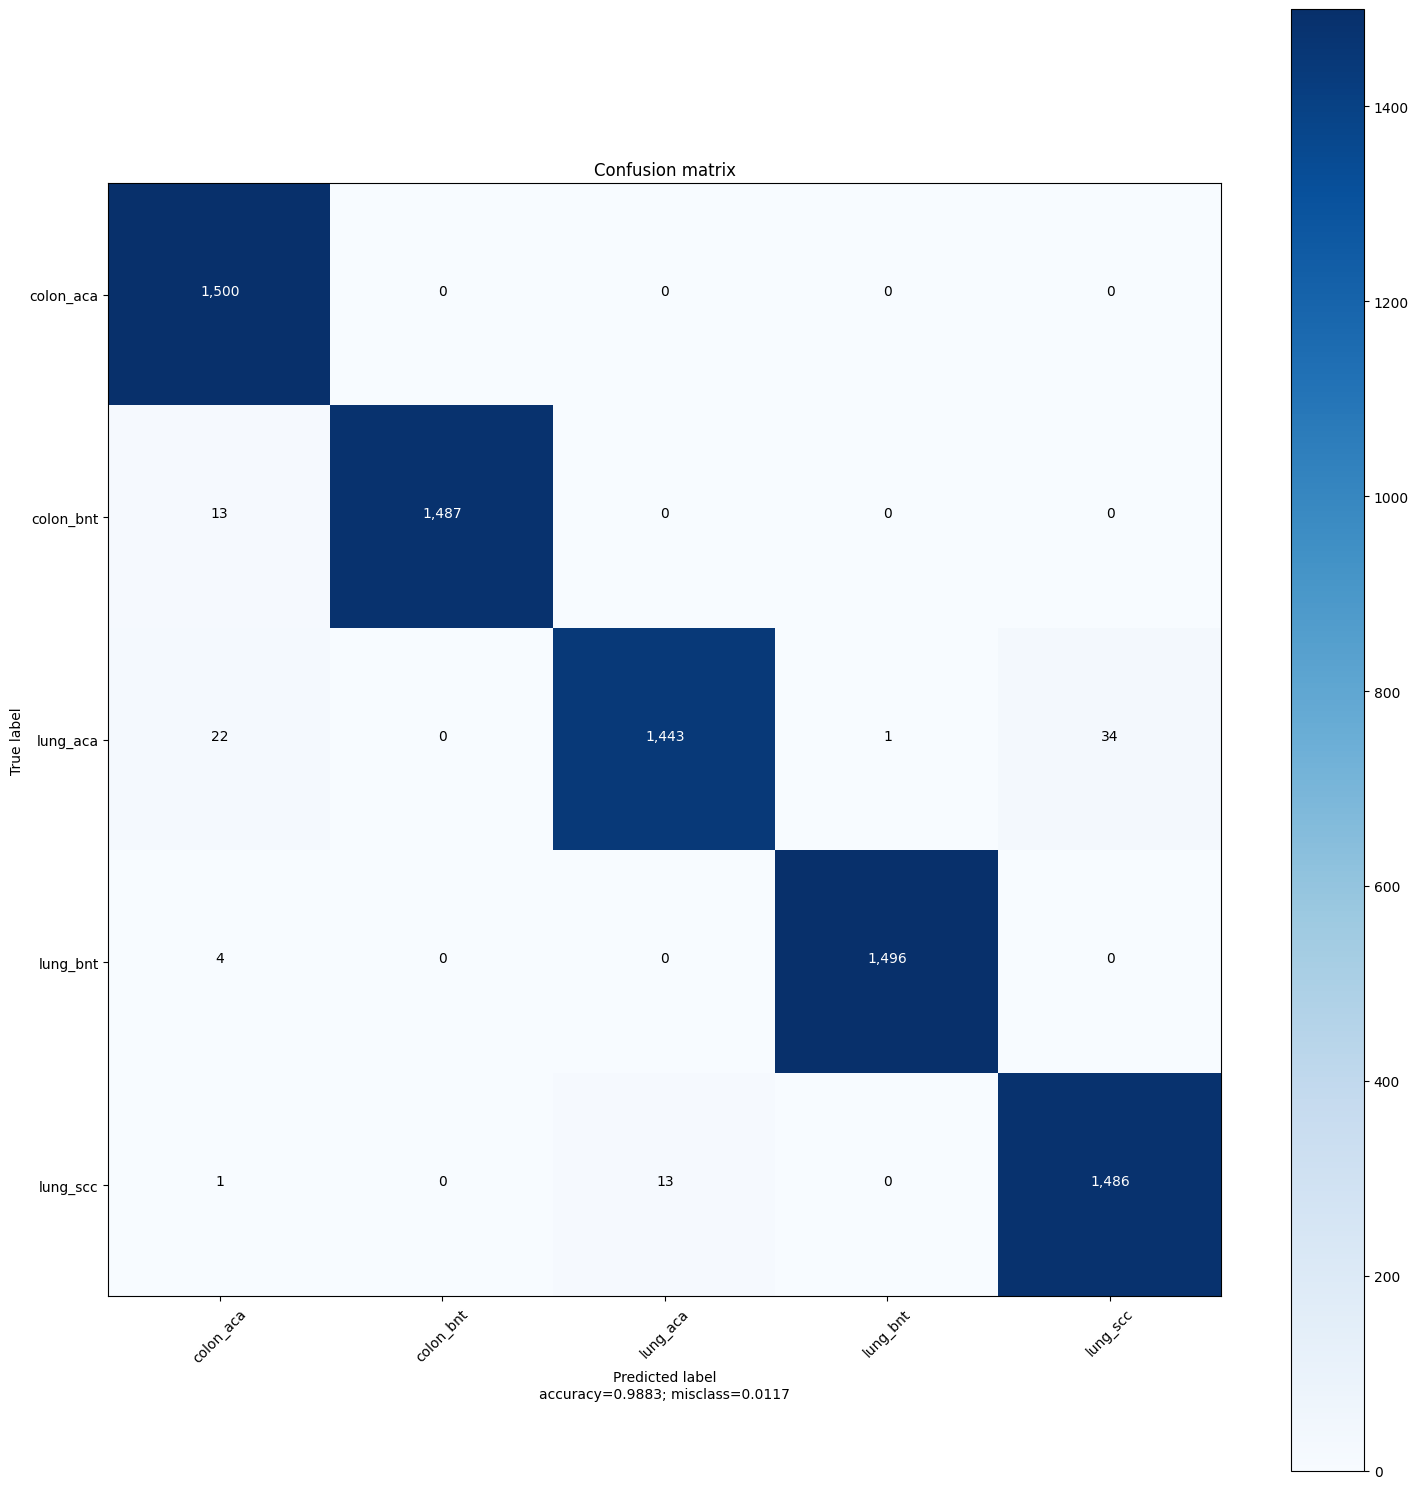

<Figure size 640x480 with 0 Axes>

In [160]:
plot_confusion_matrix(Lung_and_Colon_vgg_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)

## Resnet50

In [161]:
Resnet50_model=initiate_model_Resnet50(num_classes,
                                       image_batch,class_name)

In [162]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [163]:
Lung_and_Colon_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                                   model=Resnet50_model,
                                                                                   learning_rate=0.001)

In [164]:
Lung_and_Colon_renet50_model_fit=modelFit(Lung_and_Colon_renet50_model,
                   rlr,
                   checkpoint,
                   epochs=10,
                   batchSize = 32)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8474
Epoch 1: val_loss improved from inf to 0.21217, saving model to Lung and Colon CancerResnet50.h5
547/547 [==============================] - 210s 376ms/step - loss: 0.3697 - accuracy: 0.8474 - val_loss: 0.2122 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9101
Epoch 2: val_loss did not improve from 0.21217
547/547 [==============================] - 210s 384ms/step - loss: 0.2285 - accuracy: 0.9101 - val_loss: 0.2899 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9212
Epoch 3: val_loss improved from 0.21217 to 0.18071, saving model to Lung and Colon CancerResnet50.h5
547/547 [==============================] - 210s 384ms/step - loss: 0.1982 - accuracy: 0.9212 - val_loss: 0.1807 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 4/10
547/547 [===

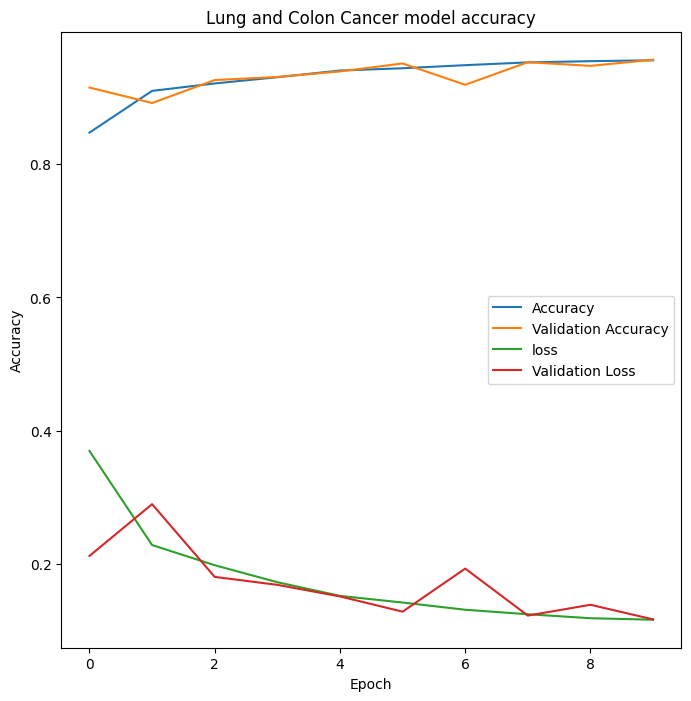

<Figure size 640x480 with 0 Axes>

In [165]:
plotOutput(hist=Lung_and_Colon_renet50_model_fit,
           className=class_name)

In [166]:
Lung_and_Colon_renet50_accuracy=evalModel(Lung_and_Colon_renet50_model)

235/235 [==============================] - 58s 246ms/step - loss: 0.1125 - accuracy: 0.9565
Accuracy on the Test Set = 95.65 %


In [167]:
saveModel_Resnet50(Lung_and_Colon_renet50_model,
                   className=class_name)

Model Saved!


235/235 [==============================] - 59s 248ms/step


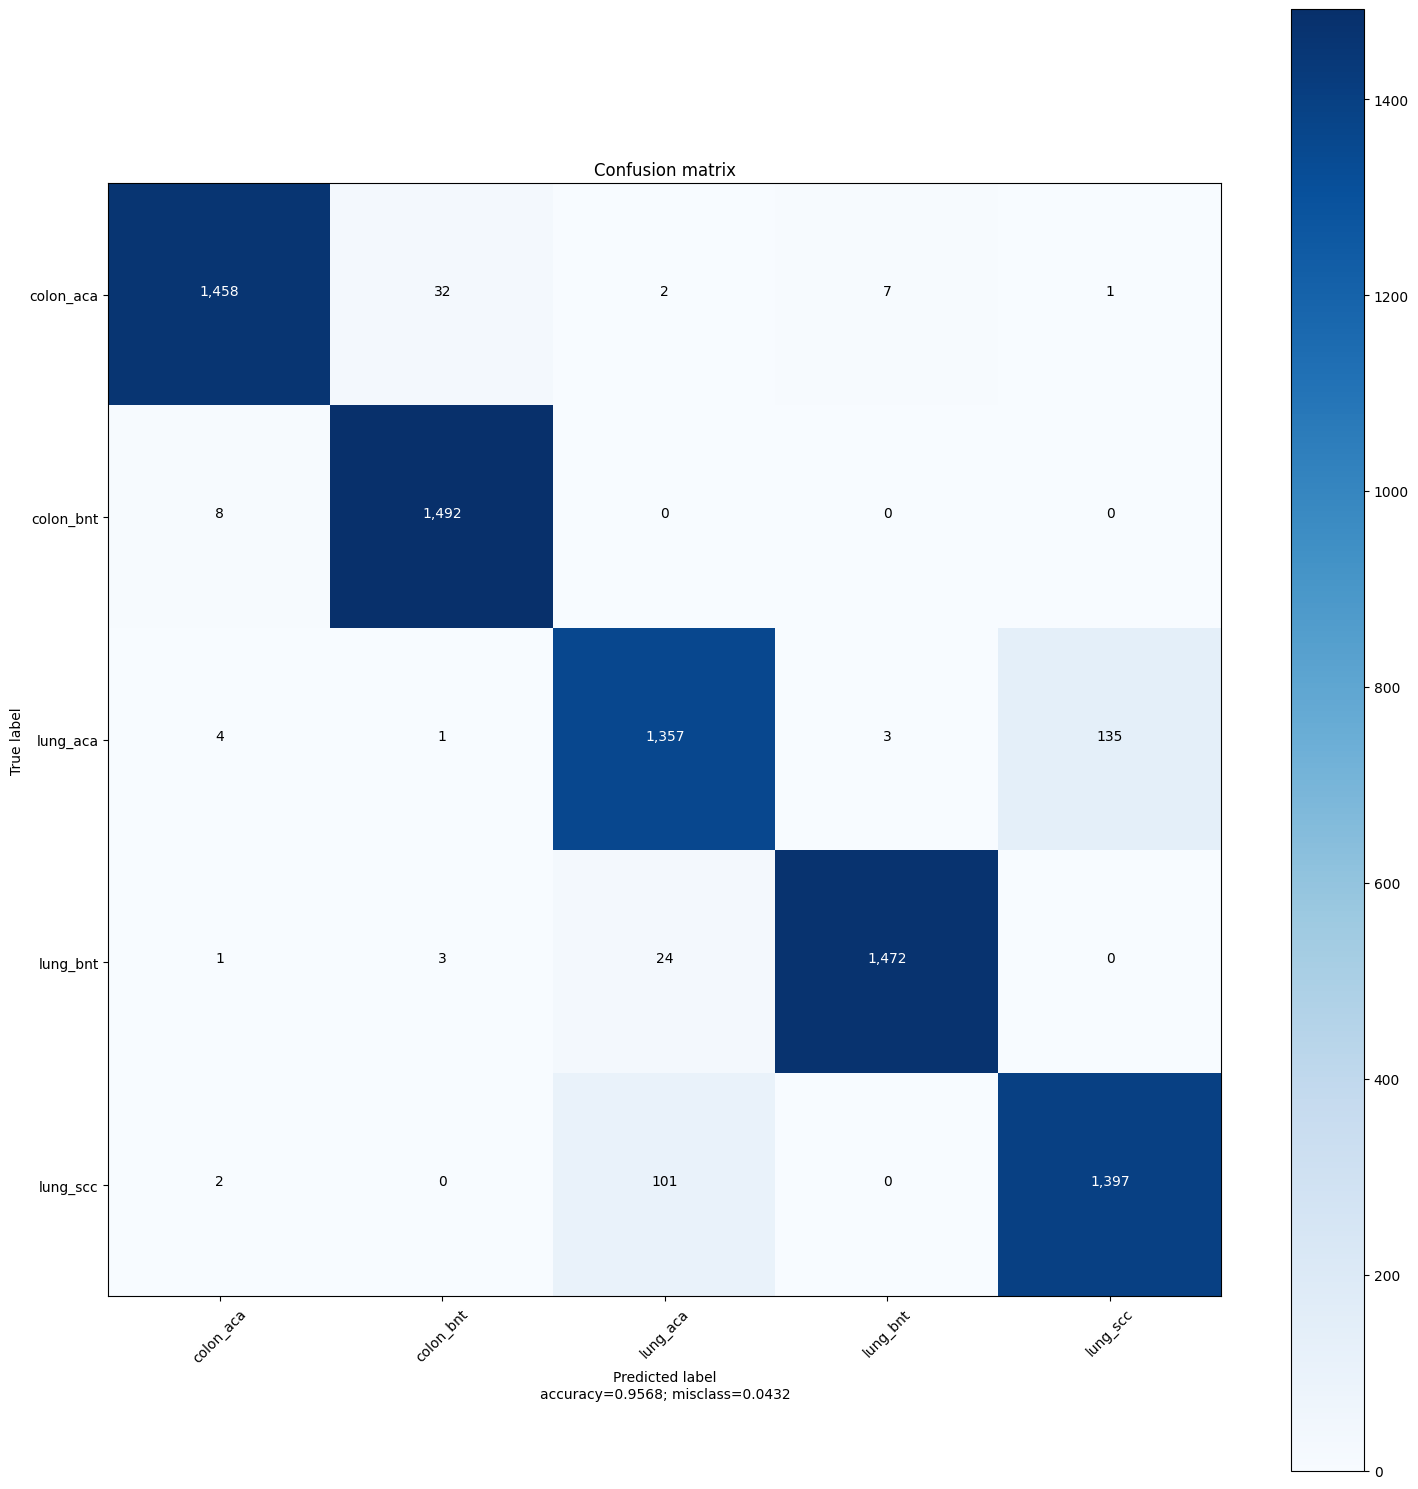

<Figure size 640x480 with 0 Axes>

In [168]:
plot_confusion_matrix(Lung_and_Colon_renet50_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)



---



---

# **Lymphoma Cancer**

In [169]:
class_name='Lymphoma'


Total for trainning and validation :  Found 15000 files belonging to 3 classes.
['lymph_cll', 'lymph_fl', 'lymph_mcl']

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.
(32, 512, 512, 3)
(32,)


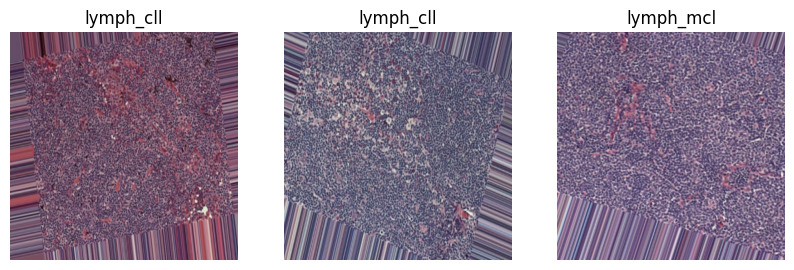

In [170]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)

## **VGG16**

In [171]:
vgg16_model=initiate_model_VGG16(num_classes,image_batch,class_name)

In [172]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [173]:
Lymphoma_vgg_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                                model=vgg16_model,
                                                                learning_rate=0.001)

In [174]:
Lymphoma_vgg_model_fit=modelFit(Lymphoma_vgg_model,
                                rlr,
                                checkpoint,
                                epochs=10,
                                batchSize = 32)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.5293
Epoch 1: val_loss improved from inf to 0.75058, saving model to LymphomaVGG16.h5
329/329 [==============================] - 133s 397ms/step - loss: 0.9253 - accuracy: 0.5293 - val_loss: 0.7506 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.7078
Epoch 2: val_loss improved from 0.75058 to 0.56294, saving model to LymphomaVGG16.h5
329/329 [==============================] - 130s 395ms/step - loss: 0.6661 - accuracy: 0.7078 - val_loss: 0.5629 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.7945
Epoch 3: val_loss improved from 0.56294 to 0.42766, saving model to LymphomaVGG16.h5
329/329 [==============================] - 130s 395ms/step - loss: 0.4915 - accuracy: 0.7945 - val_loss: 0.4277 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 4/10
329/32

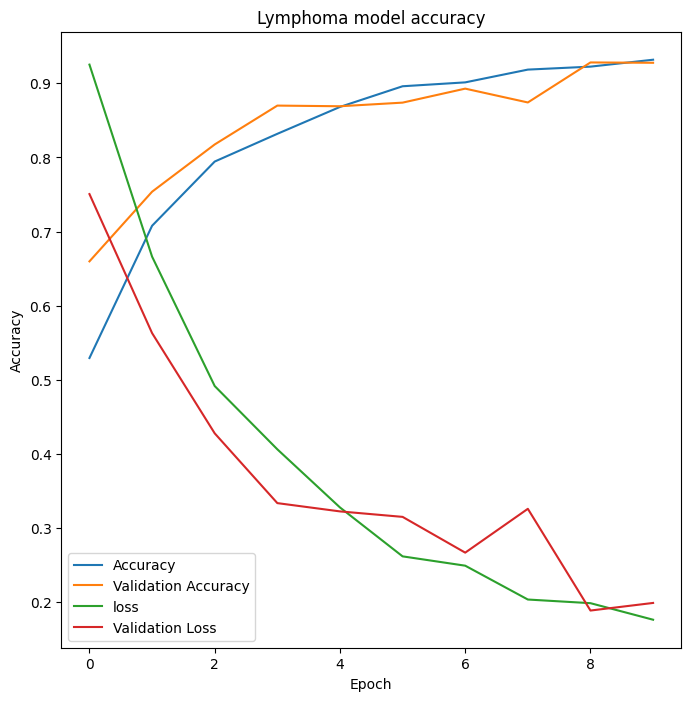

<Figure size 640x480 with 0 Axes>

In [175]:
plotOutput(hist=Lymphoma_vgg_model_fit,
           className=class_name)

In [177]:
Lymphoma_vgg_accuracy=evalModel(Lymphoma_vgg_model)

141/141 [==============================] - 38s 270ms/step - loss: 0.2057 - accuracy: 0.9238
Accuracy on the Test Set = 92.38 %


In [178]:
saveModel(Lymphoma_vgg_model,
          className=class_name)

Model Saved!


141/141 [==============================] - 38s 267ms/step


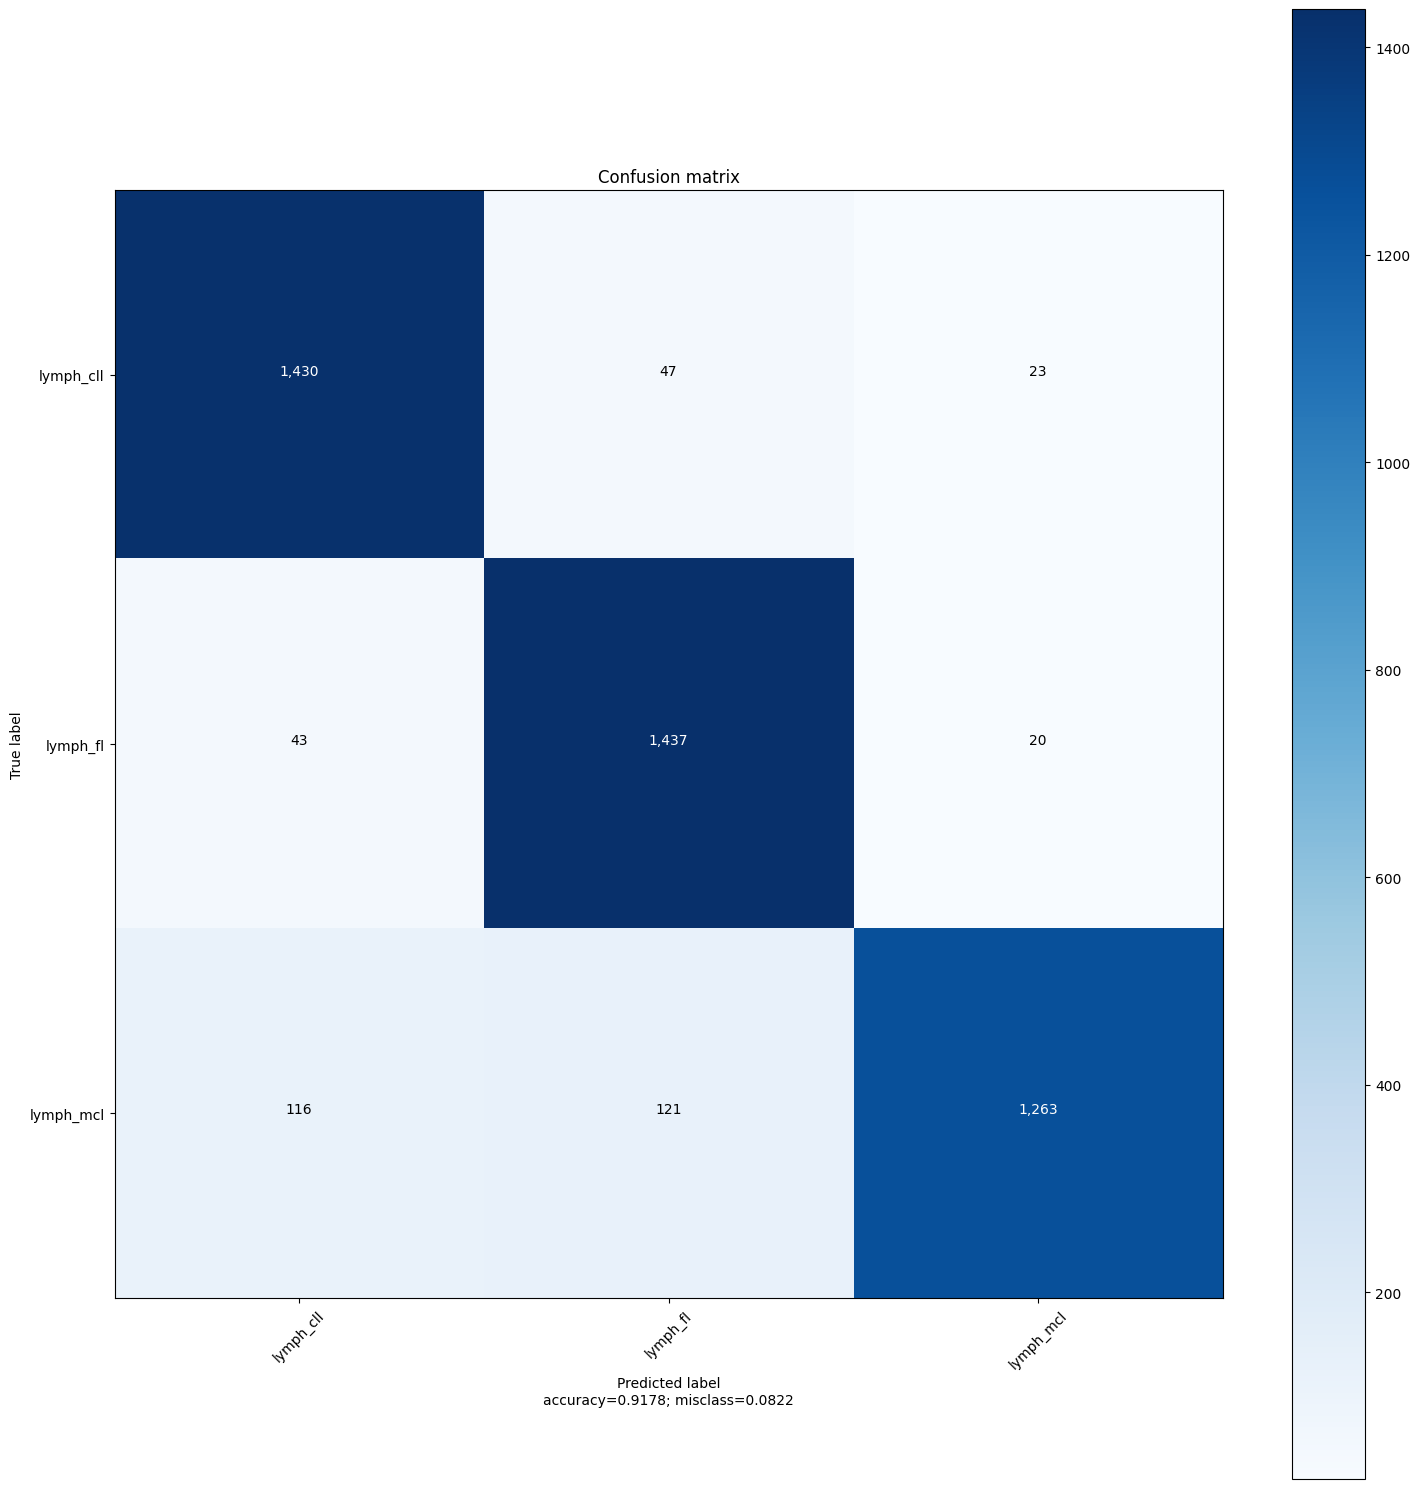

<Figure size 640x480 with 0 Axes>

In [179]:
plot_confusion_matrix(Lymphoma_vgg_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)

## Resnet50

In [180]:
Resnet50_model=initiate_model_Resnet50(num_classes,
                                       image_batch,class_name)

In [181]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [182]:
Lymphoma_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                             model=Resnet50_model,
                                                                             learning_rate=0.001)

In [185]:
Lymphoma_renet50_model_fit=modelFit(Lymphoma_renet50_model,
                   rlr,
                   checkpoint,
                   epochs=10,
                   batchSize = 32)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8364
Epoch 1: val_loss improved from 0.47045 to 0.39437, saving model to LymphomaResnet50.h5
329/329 [==============================] - 139s 423ms/step - loss: 0.4052 - accuracy: 0.8364 - val_loss: 0.3944 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8390
Epoch 2: val_loss improved from 0.39437 to 0.37262, saving model to LymphomaResnet50.h5
329/329 [==============================] - 139s 424ms/step - loss: 0.3961 - accuracy: 0.8390 - val_loss: 0.3726 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8485
Epoch 3: val_loss did not improve from 0.37262
329/329 [==============================] - 138s 419ms/step - loss: 0.3698 - accuracy: 0.8485 - val_loss: 0.3775 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 4/10
329/329 [=========================

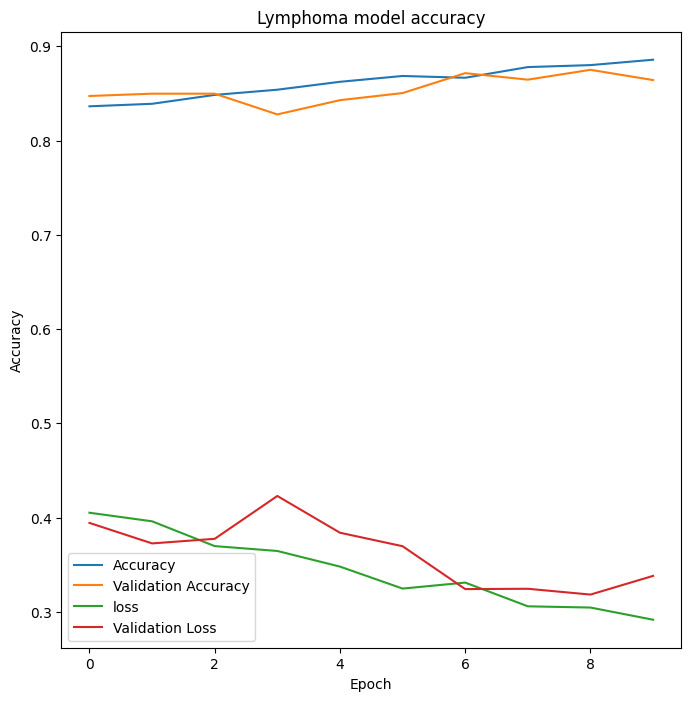

<Figure size 640x480 with 0 Axes>

In [186]:
plotOutput(hist=Lymphoma_renet50_model_fit,
           className=class_name)

In [188]:
Lymphoma_renet50_accuracy=evalModel(Lymphoma_renet50_model)

141/141 [==============================] - 38s 268ms/step - loss: 0.3410 - accuracy: 0.8669
Accuracy on the Test Set = 86.69 %


In [189]:
saveModel_Resnet50(Lymphoma_renet50_model,
                   className=class_name)

Model Saved!


141/141 [==============================] - 41s 285ms/step


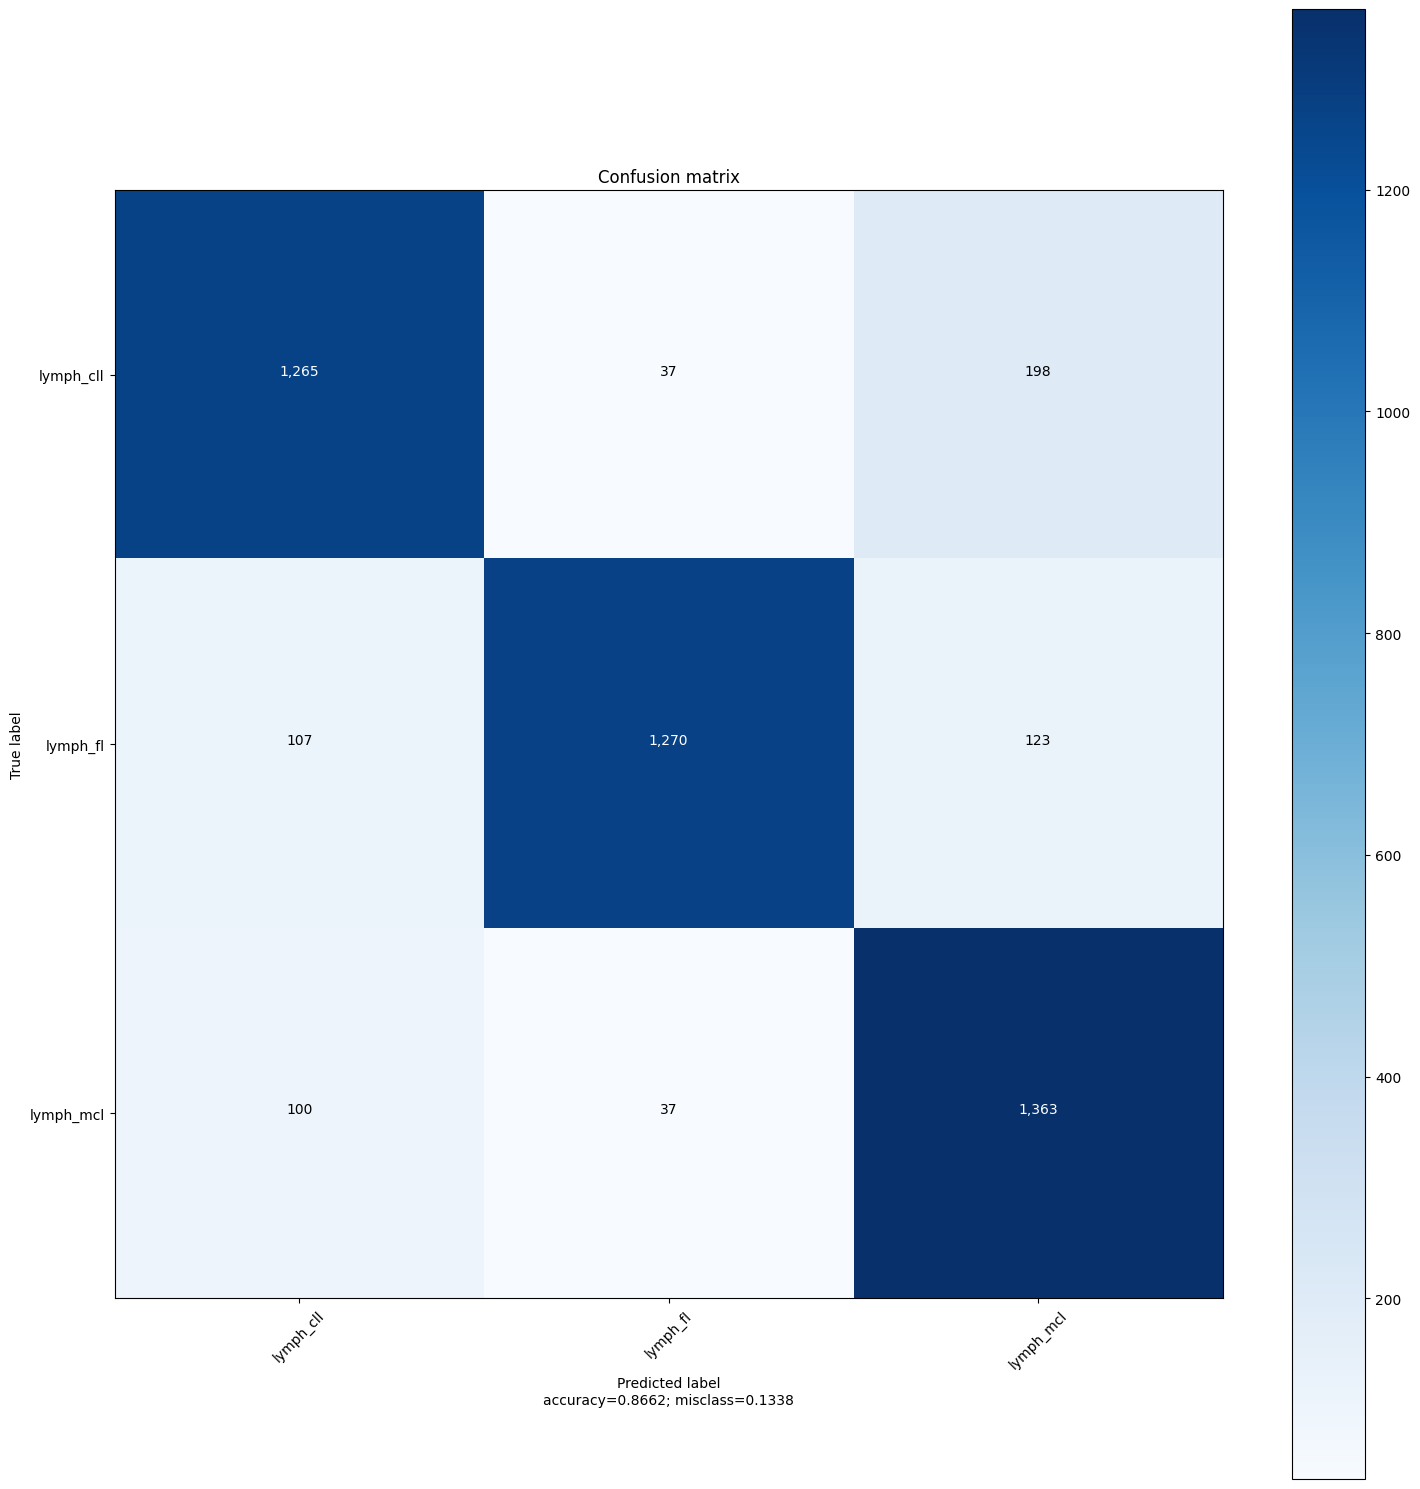

<Figure size 640x480 with 0 Axes>

In [190]:
plot_confusion_matrix(Lymphoma_renet50_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)



---



---

# **Oral Cancer**

In [191]:
class_name='Oral Cancer'


Total for trainning and validation :  Found 10002 files belonging to 2 classes.
['oral_normal', 'oral_scc']

For Training :  Found 7002 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.
(32, 512, 512, 3)
(32,)


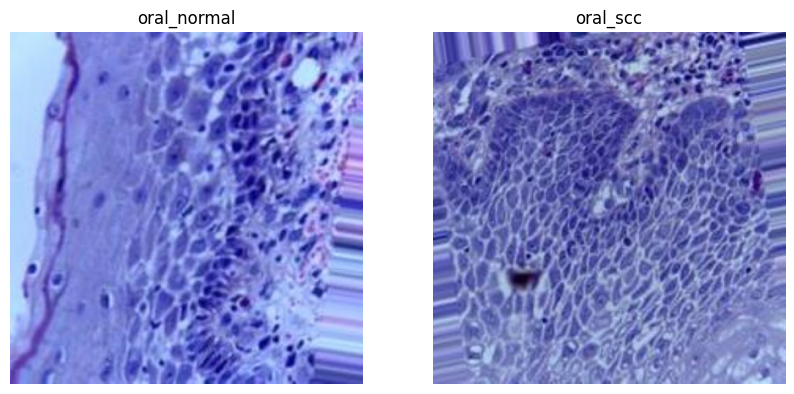

In [192]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)

## **VGG16**

In [193]:
vgg16_model=initiate_model_VGG16(num_classes,
                                 image_batch,class_name)

In [194]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [195]:
oral_vgg_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                            model=vgg16_model,
                                                            learning_rate=0.001)

In [196]:
oral_vgg_model_fit=modelFit(oral_vgg_model,
                            rlr,
                            checkpoint,
                            epochs=10,
                            batchSize = 32)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.7308
Epoch 1: val_loss improved from inf to 0.43858, saving model to Oral CancerVGG16.h5
219/219 [==============================] - 87s 391ms/step - loss: 0.5282 - accuracy: 0.7308 - val_loss: 0.4386 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8336
Epoch 2: val_loss improved from 0.43858 to 0.34482, saving model to Oral CancerVGG16.h5
219/219 [==============================] - 84s 383ms/step - loss: 0.3755 - accuracy: 0.8336 - val_loss: 0.3448 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8760
Epoch 3: val_loss did not improve from 0.34482
219/219 [==============================] - 82s 376ms/step - loss: 0.2828 - accuracy: 0.8760 - val_loss: 0.3528 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 4/10
219/219 [==============================] 

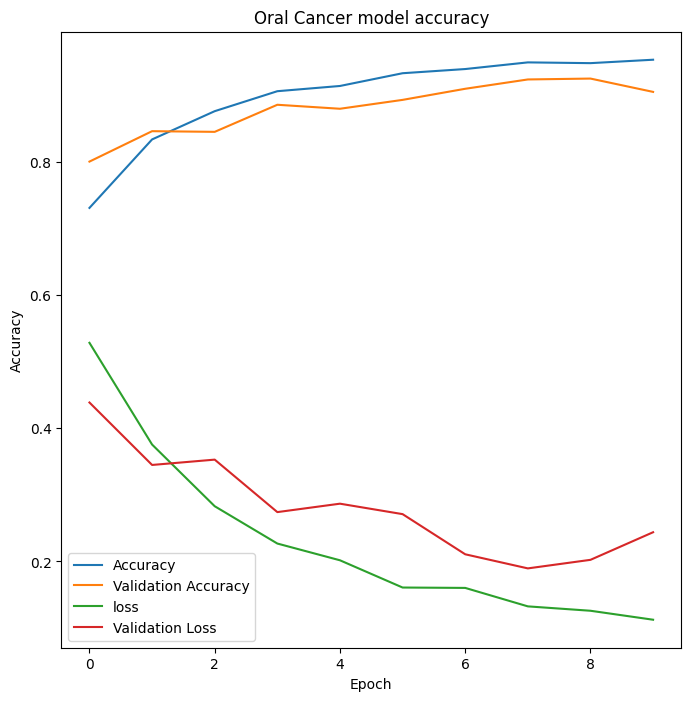

<Figure size 640x480 with 0 Axes>

In [197]:
plotOutput(hist=oral_vgg_model_fit,
           className=class_name)

In [198]:
oral_vgg_accuracy=evalModel(oral_vgg_model)

94/94 [==============================] - 23s 246ms/step - loss: 0.2441 - accuracy: 0.9013
Accuracy on the Test Set = 90.13 %


In [199]:
saveModel(oral_vgg_model,
          className=class_name)

Model Saved!


94/94 [==============================] - 23s 238ms/step


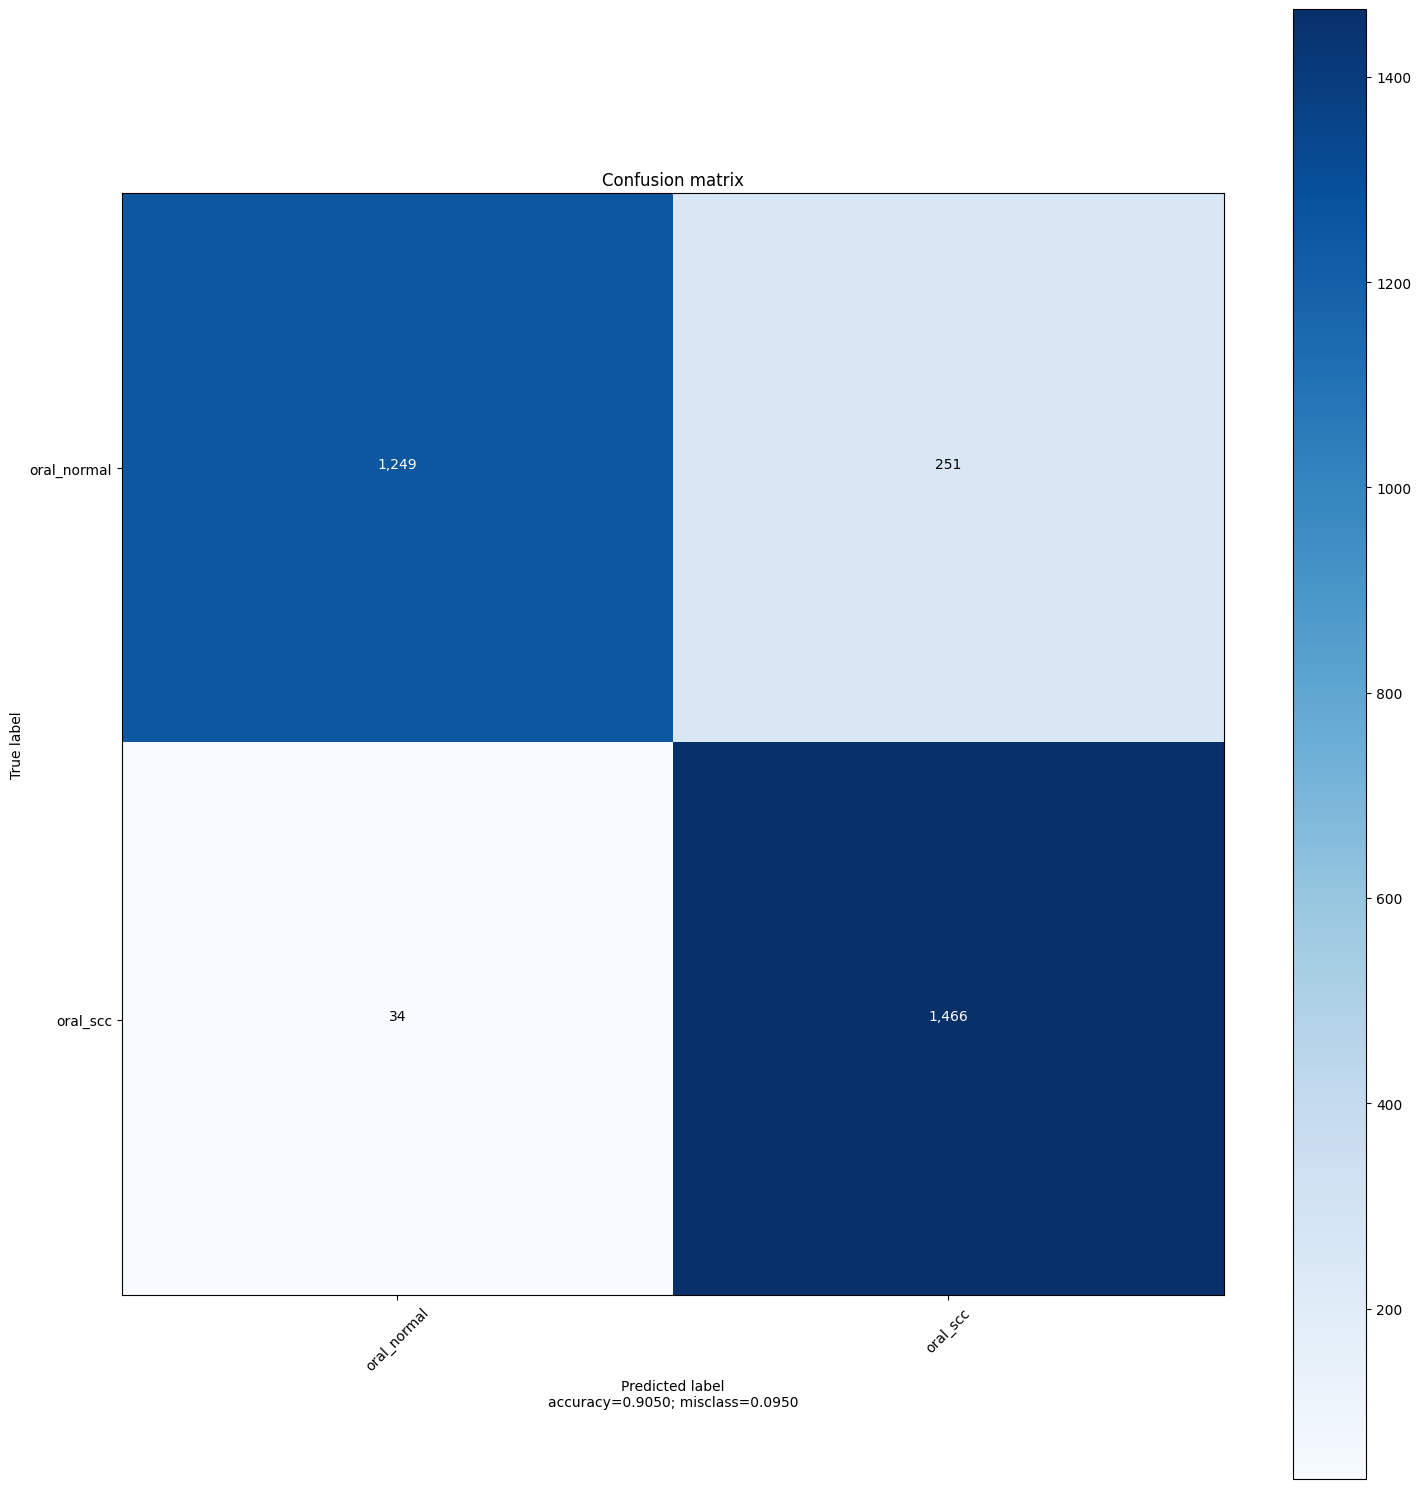

<Figure size 640x480 with 0 Axes>

In [200]:
plot_confusion_matrix(oral_vgg_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)

## Resnet50

In [201]:
Resnet50_model=initiate_model_Resnet50(num_classes,
                                       image_batch,class_name)

In [202]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [203]:
oral_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                         model=Resnet50_model,
                                                                         learning_rate=0.001)

In [204]:
oral_renet50_model_fit=modelFit(oral_renet50_model,
                                rlr,
                                checkpoint,
                                epochs=10,
                                batchSize = 32)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.6692
Epoch 1: val_loss improved from inf to 0.53711, saving model to Oral CancerResnet50.h5
219/219 [==============================] - 89s 392ms/step - loss: 0.6022 - accuracy: 0.6692 - val_loss: 0.5371 - val_accuracy: 0.7280 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.7382
Epoch 2: val_loss improved from 0.53711 to 0.50267, saving model to Oral CancerResnet50.h5
219/219 [==============================] - 83s 377ms/step - loss: 0.5221 - accuracy: 0.7382 - val_loss: 0.5027 - val_accuracy: 0.7503 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.7771
Epoch 3: val_loss improved from 0.50267 to 0.45303, saving model to Oral CancerResnet50.h5
219/219 [==============================] - 82s 375ms/step - loss: 0.4628 - accuracy: 0.7771 - val_loss: 0.4530 - val_accuracy: 0.7840 - lr: 0.0010
Ep

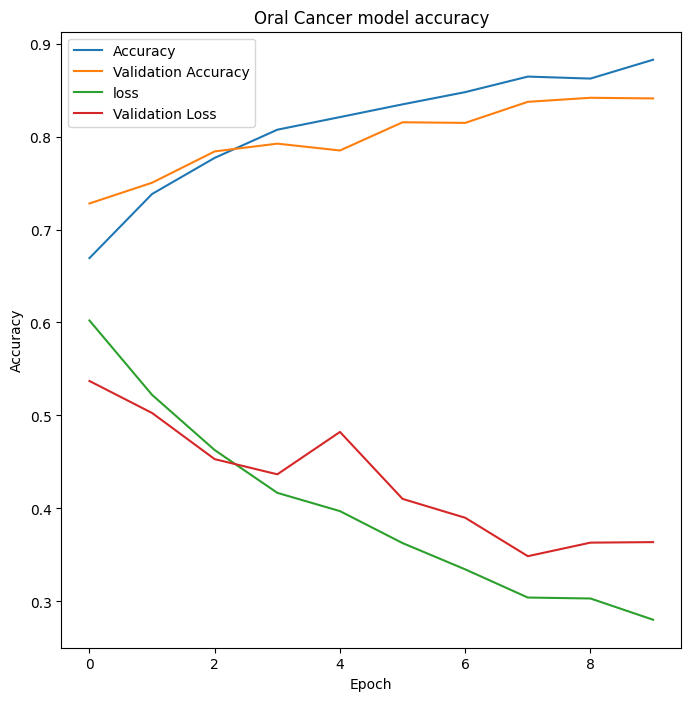

<Figure size 640x480 with 0 Axes>

In [205]:
plotOutput(hist=oral_renet50_model_fit, className=class_name)

In [206]:
oral_renet50_accuracy=evalModel(oral_renet50_model)

94/94 [==============================] - 24s 248ms/step - loss: 0.3844 - accuracy: 0.8347
Accuracy on the Test Set = 83.47 %


In [207]:
saveModel_Resnet50(oral_renet50_model,
                   className=class_name)

Model Saved!


94/94 [==============================] - 24s 246ms/step


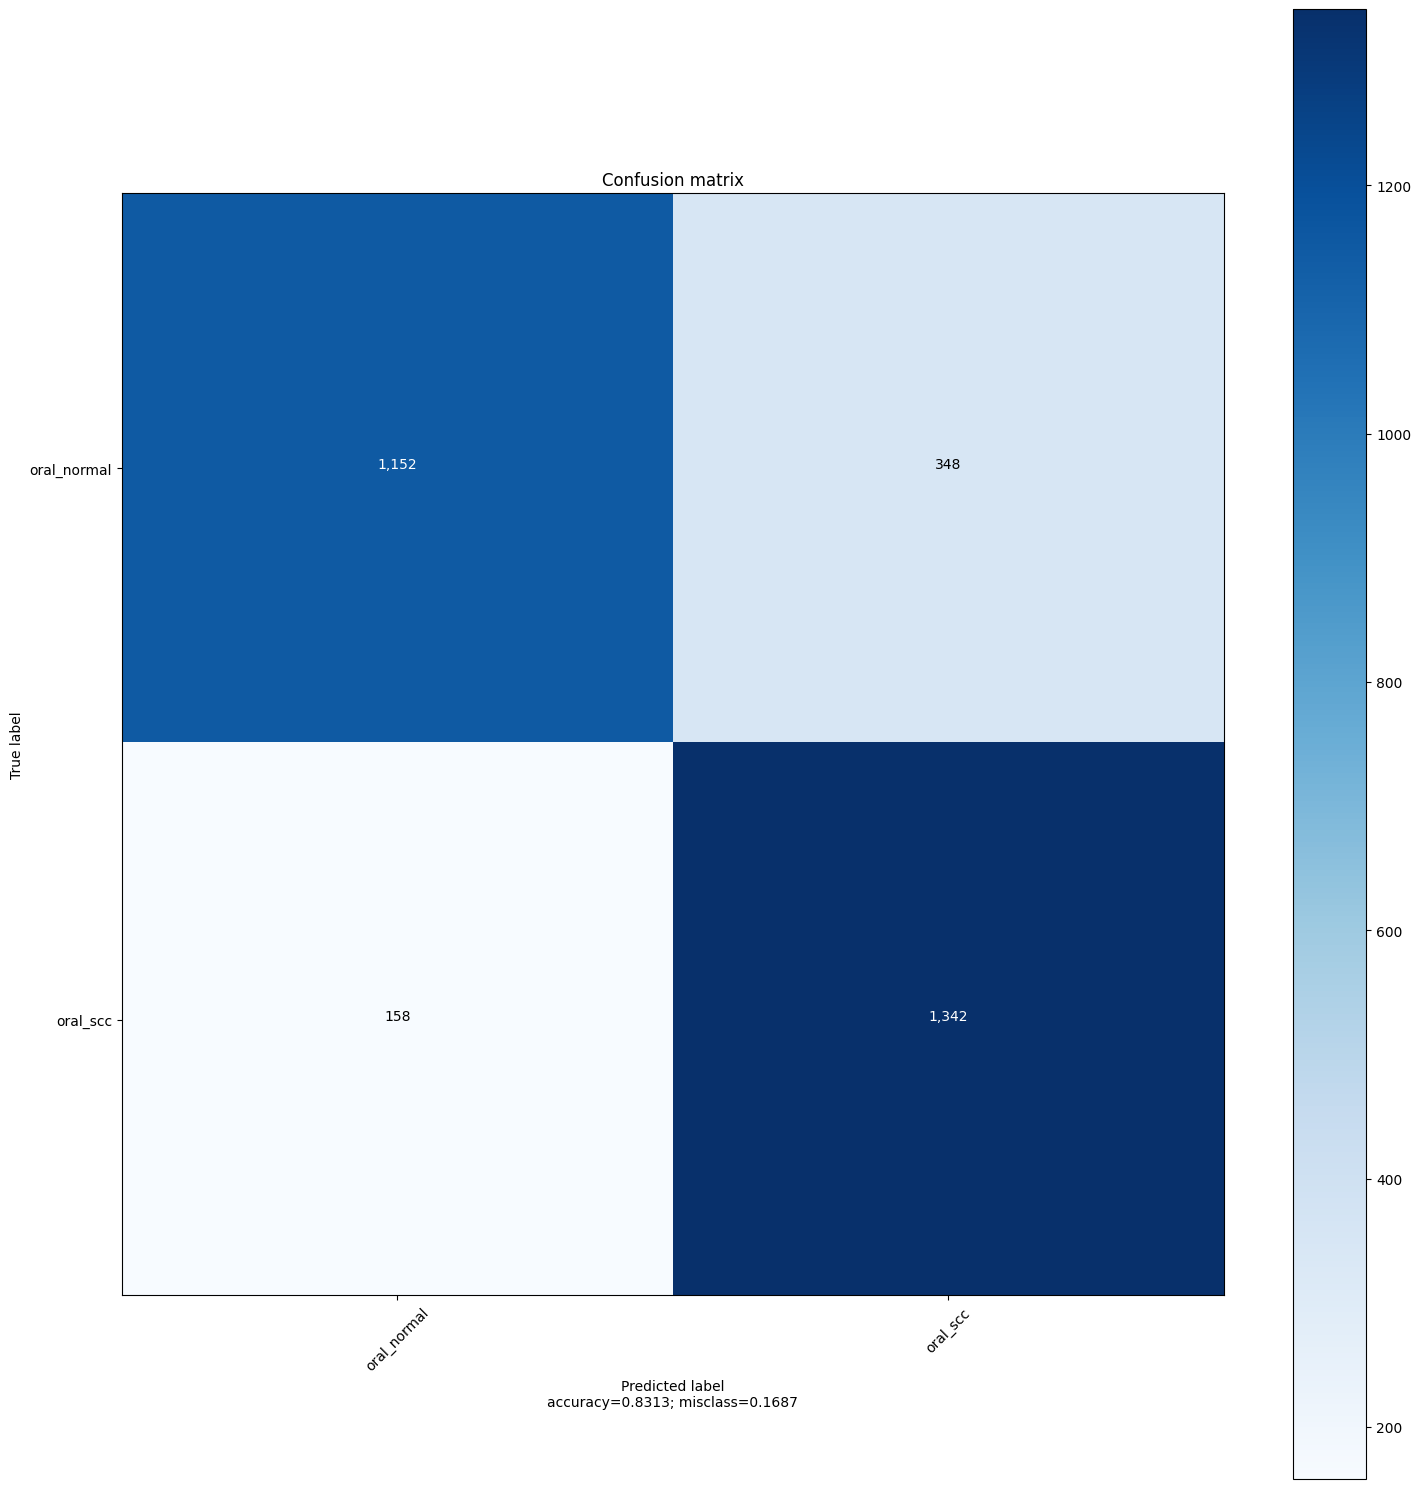

<Figure size 640x480 with 0 Axes>

In [208]:
plot_confusion_matrix(oral_renet50_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)



---



---

# **Acute Lymphoblastic Leukemia Cancer**

In [209]:
class_name='ALL'


Total for trainning and validation :  Found 20000 files belonging to 4 classes.
['all_benign', 'all_early', 'all_pre', 'all_pro']

For Training :  Found 14000 images belonging to 4 classes.

For Val :  Found 6000 images belonging to 4 classes.
(32, 512, 512, 3)
(32,)


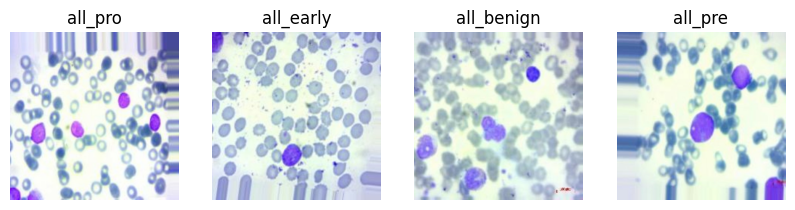

In [210]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path+class_name)

## **VGG16**

In [211]:
vgg16_model=initiate_model_VGG16(num_classes,
                                 image_batch,class_name)

In [212]:
modelSummary(vgg16_model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [213]:
all_vgg_model, rlr, checkpoint=initiateParams_modelComplie(className=class_name,
                                                   model=vgg16_model,
                                                   learning_rate=0.001)

In [214]:
all_vgg_model_fit=modelFit(all_vgg_model,
                           rlr,
                           checkpoint,
                           epochs=10,
                           batchSize = 32)

Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9309
Epoch 1: val_loss improved from inf to 0.06114, saving model to ALLVGG16.h5
438/438 [==============================] - 160s 360ms/step - loss: 0.1918 - accuracy: 0.9309 - val_loss: 0.0611 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 2/10
438/438 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9829
Epoch 2: val_loss improved from 0.06114 to 0.02535, saving model to ALLVGG16.h5
438/438 [==============================] - 158s 360ms/step - loss: 0.0539 - accuracy: 0.9829 - val_loss: 0.0254 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 3/10
438/438 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9872
Epoch 3: val_loss improved from 0.02535 to 0.02286, saving model to ALLVGG16.h5
438/438 [==============================] - 159s 364ms/step - loss: 0.0362 - accuracy: 0.9872 - val_loss: 0.0229 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 4/10
438/438 [============

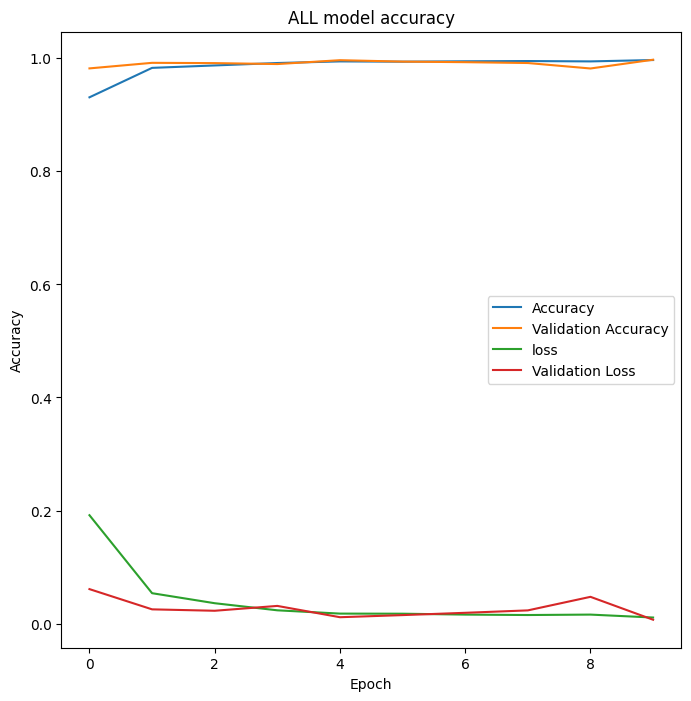

<Figure size 640x480 with 0 Axes>

In [215]:
plotOutput(hist=all_vgg_model_fit,
           className=class_name)

In [216]:
all_vgg_accuracy=evalModel(all_vgg_model)

188/188 [==============================] - 48s 253ms/step - loss: 0.0036 - accuracy: 0.9990
Accuracy on the Test Set = 99.90 %


In [217]:
saveModel(all_vgg_model,
          className=class_name)

Model Saved!


188/188 [==============================] - 49s 257ms/step


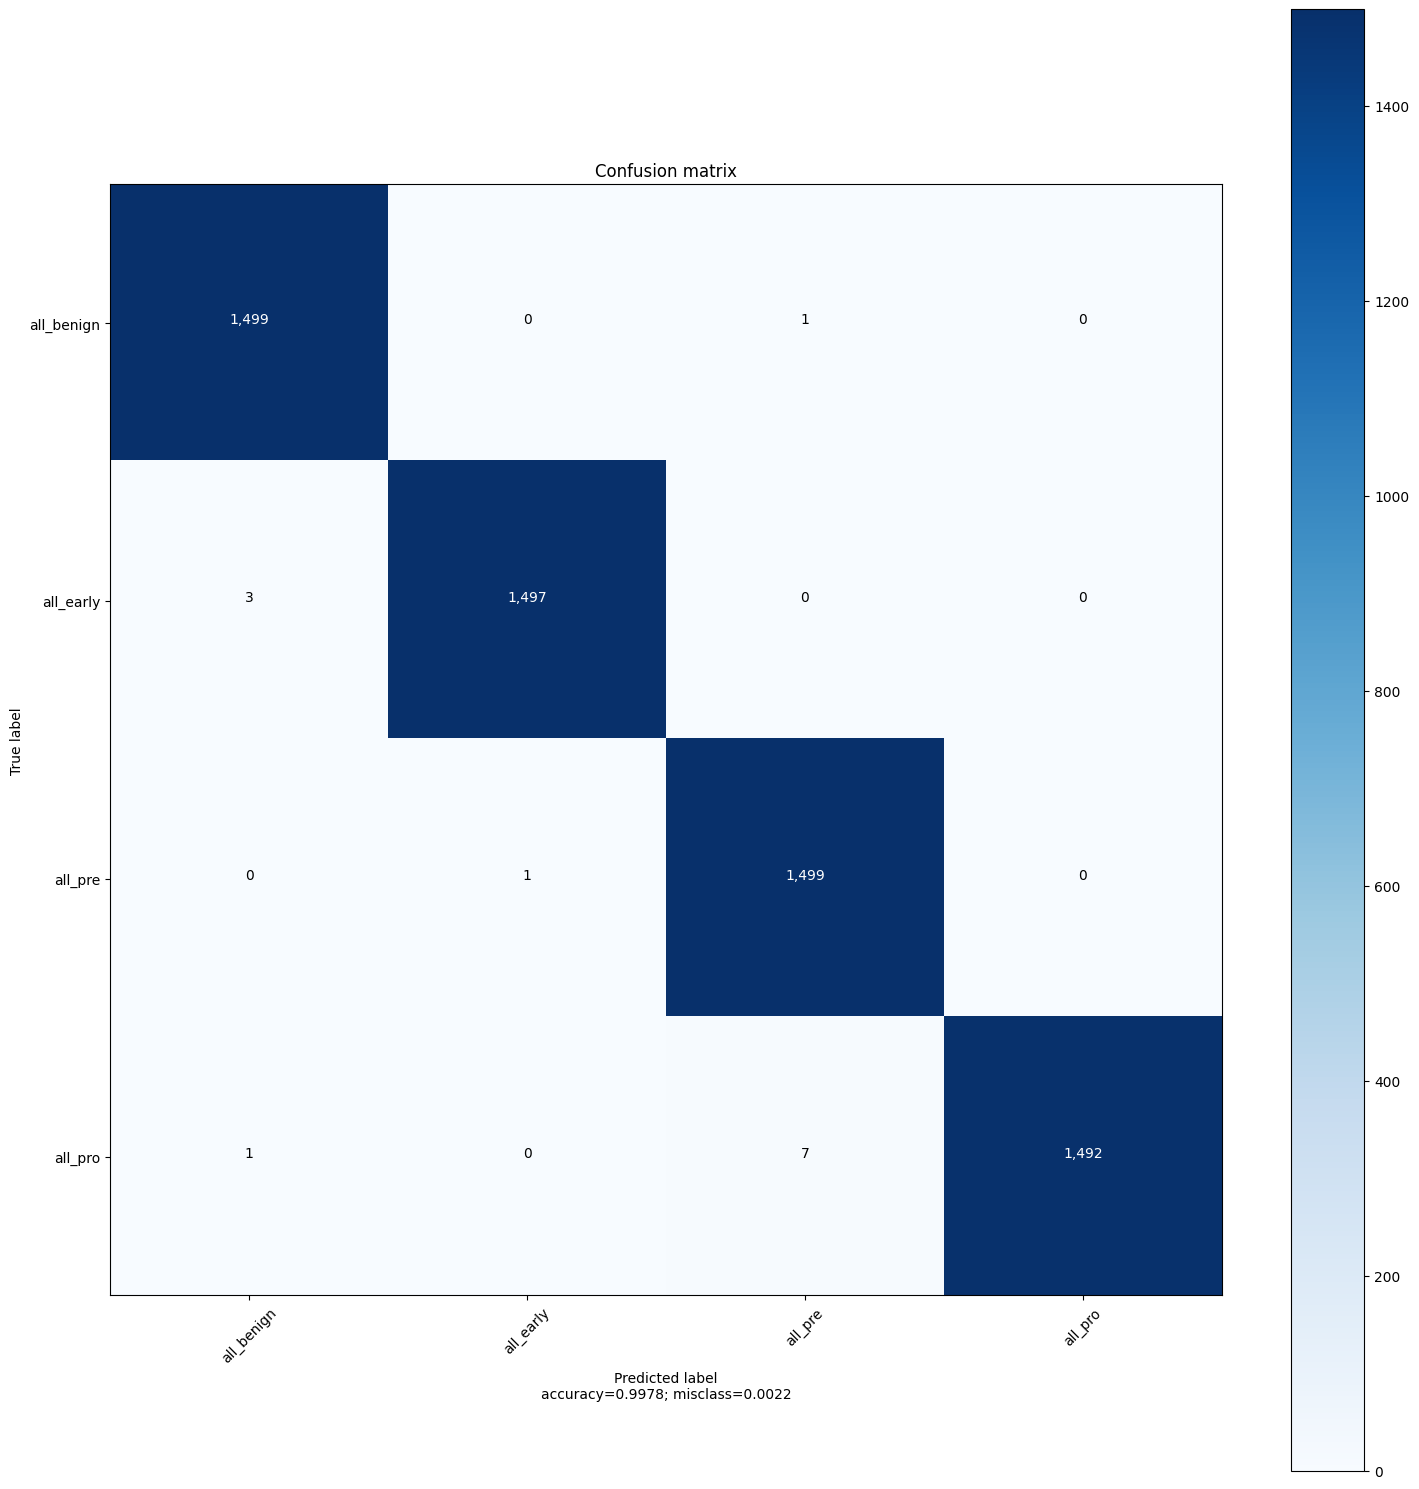

<Figure size 640x480 with 0 Axes>

In [218]:
plot_confusion_matrix(all_vgg_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)

## Resnet50

In [219]:
Resnet50_model=initiate_model_Resnet50(num_classes,
                                       image_batch,class_name)

In [220]:
modelSummary(Resnet50_model)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_22[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [221]:
all_renet50_model, rlr, checkpoint=initiateParams_modelComplie_Resnet50(className=class_name,
                                                                        model=Resnet50_model,
                                                                        learning_rate=0.001)

In [222]:
all_renet50_model_fit=modelFit(all_renet50_model,
                               rlr,
                               checkpoint,
                               epochs=10,
                               batchSize = 32)

Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8908
Epoch 1: val_loss improved from inf to 0.16139, saving model to ALLResnet50.h5
438/438 [==============================] - 163s 364ms/step - loss: 0.2932 - accuracy: 0.8908 - val_loss: 0.1614 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 2/10
438/438 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9572
Epoch 2: val_loss improved from 0.16139 to 0.07966, saving model to ALLResnet50.h5
438/438 [==============================] - 156s 357ms/step - loss: 0.1207 - accuracy: 0.9572 - val_loss: 0.0797 - val_accuracy: 0.9757 - lr: 0.0010
Epoch 3/10
438/438 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9639
Epoch 3: val_loss did not improve from 0.07966
438/438 [==============================] - 158s 361ms/step - loss: 0.0985 - accuracy: 0.9639 - val_loss: 0.0806 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 4/10
438/438 [==============================] - ETA: 

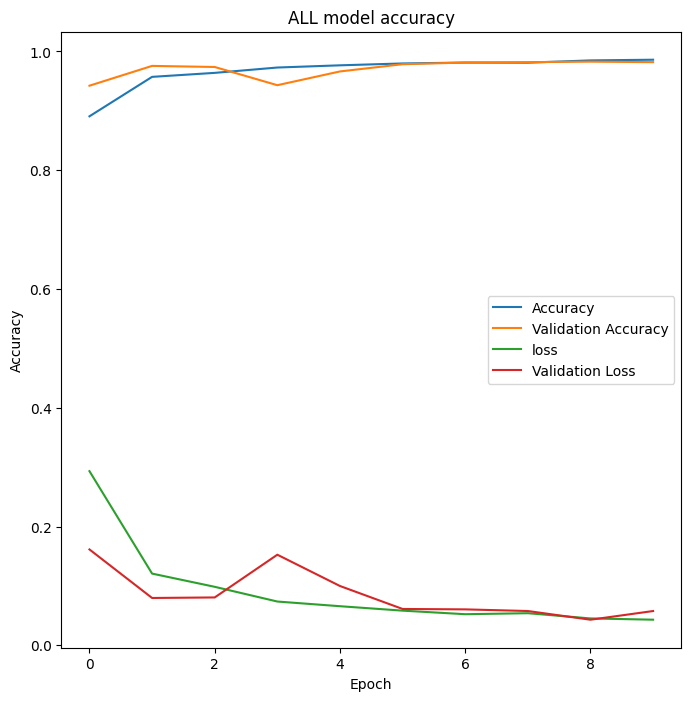

<Figure size 640x480 with 0 Axes>

In [223]:
plotOutput(hist=all_renet50_model_fit,
           className=class_name)

In [224]:
all_renet50_accuracy=evalModel(all_renet50_model)

188/188 [==============================] - 47s 247ms/step - loss: 0.0530 - accuracy: 0.9825
Accuracy on the Test Set = 98.25 %


In [225]:
saveModel_Resnet50(all_renet50_model,
                   className=class_name)

Model Saved!


188/188 [==============================] - 48s 249ms/step


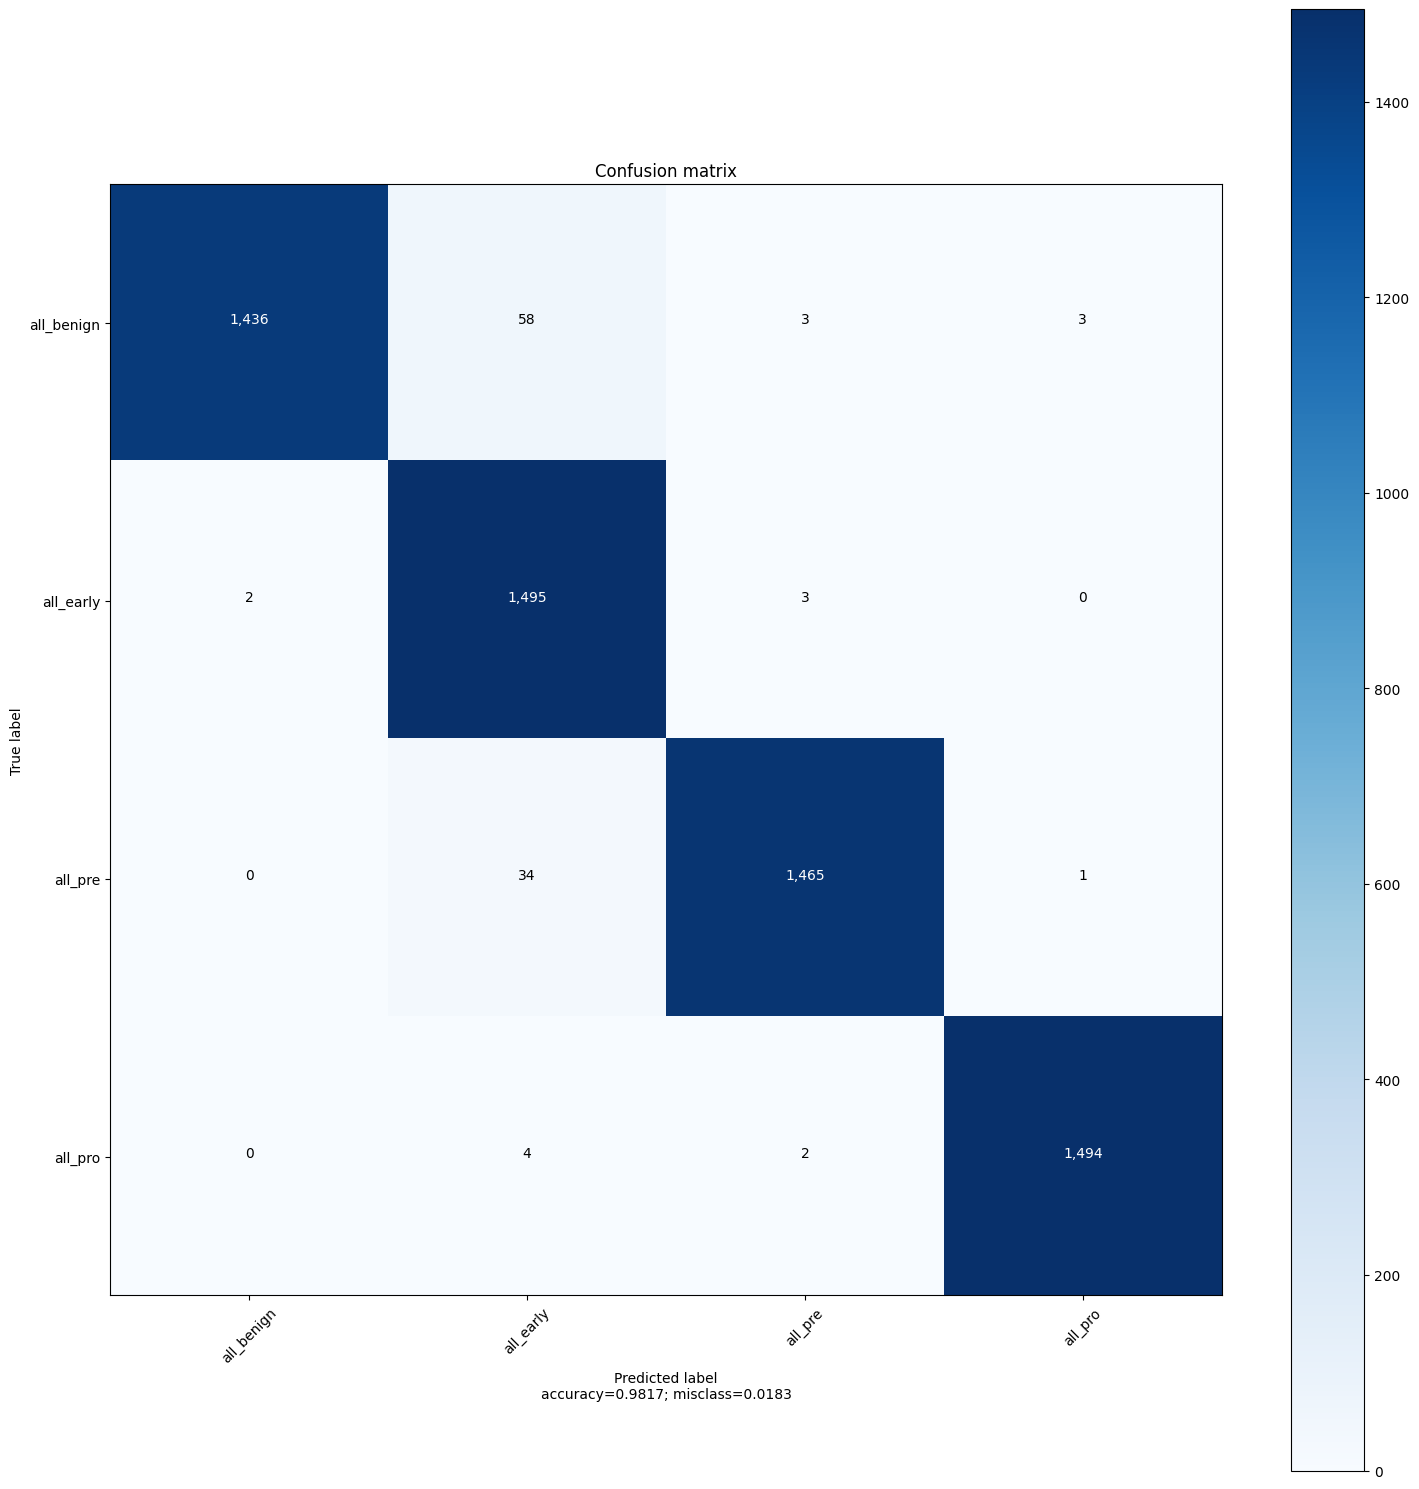

<Figure size 640x480 with 0 Axes>

In [226]:
plot_confusion_matrix(all_renet50_model,
                      className=class_name,
                      classes=class_names,
                      normalize=False)

# Models accuracy comparison

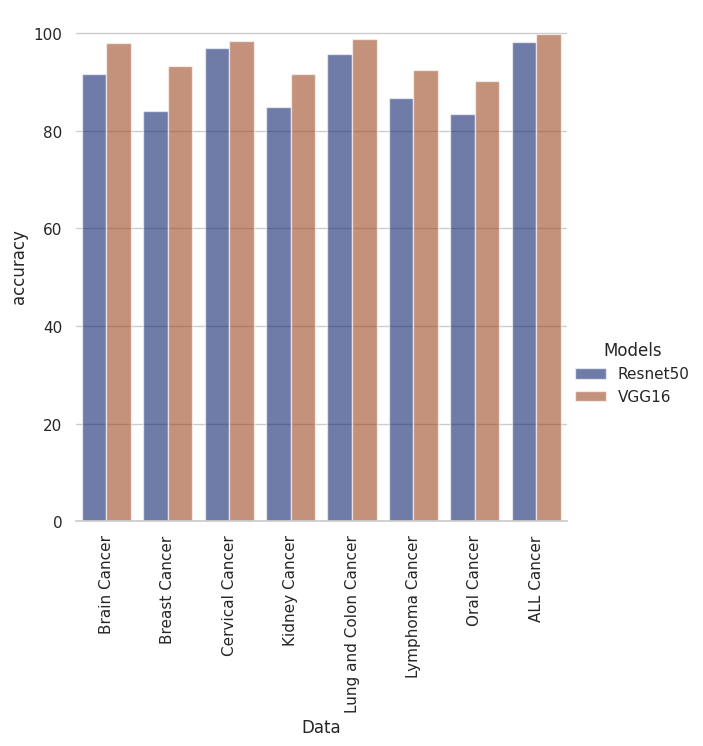

In [229]:
sns.set_theme(style="whitegrid")

da=pd.DataFrame({'models': ['Resnet50', 'VGG16', 'Resnet50', 'VGG16','Resnet50',
                            'VGG16','Resnet50', 'VGG16','Resnet50', 'VGG16','Resnet50',
                            'VGG16','Resnet50', 'VGG16','Resnet50', 'VGG16'],
                  'data': ['Brain Cancer', 'Brain Cancer', 'Breast Cancer', 'Breast Cancer',
                           'Cervical Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Kidney Cancer'
                          ,'Lung and Colon Cancer','Lung and Colon Cancer','Lymphoma Cancer','Lymphoma Cancer'
                           ,'Oral Cancer','Oral Cancer','ALL Cancer',
                           'ALL Cancer'],
                  'accuracy': [ brain_renet50_accuracy,brain_vgg16_accuracy,
                               breast_renet50_accuracy,breast_vgg_accuracy,
                               Cervical_renet50_accuracy,Cervical_vgg_accuracy
                              ,Kidney_renet50_accuracy,Kidney_vgg_accuracy
                              ,Lung_and_Colon_renet50_accuracy,Lung_and_Colon_vgg_accuracy
                              ,Lymphoma_renet50_accuracy,Lymphoma_vgg_accuracy
                               ,oral_renet50_accuracy,oral_vgg_accuracy
                               ,all_renet50_accuracy,all_vgg_accuracy]})

g = sns.catplot(
    data=da, kind="bar",
    x='data',y='accuracy',hue='models',
    errorbar="sd", palette="dark", alpha=.6, height=6
)
plt.xticks(rotation=90)
g.despine(left=True)
g.set_axis_labels("Data", "accuracy")
g.legend.set_title("Models")

# Models trainning and validation loss and accuracy throw epocs comparison

In [230]:
def plot_loss(hist_vgg,hist_resnet, className):
    loss_vgg = hist_vgg.history['loss']
    val_loss_vgg = hist_vgg.history['val_loss']

    loss_resnet = hist_resnet.history['loss']
    val_loss_resnet =hist_resnet.history['val_loss']

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot( loss_vgg, label='Training Loss')
    plt.plot( val_loss_vgg, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss VGG16')

    plt.subplot(3, 2, 2)
    plt.plot( loss_resnet, label='Training Loss')
    plt.plot( val_loss_resnet, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss Resnet50')
    plt.show()
    plt.savefig(className + '_graph.png')

In [231]:
def plot_acc(hist_vgg,hist_resnet, className):
    acc_vgg = hist_vgg.history['accuracy']
    val_acc_vgg = hist_vgg.history['val_accuracy']

    acc_resnet = hist_resnet.history['accuracy']
    val_acc_resnet =hist_resnet.history['val_accuracy']


    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(acc_vgg, label='Training Accuracy')
    plt.plot(val_acc_vgg, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy VGG16')

    plt.subplot(3, 2, 2)
    plt.plot( acc_resnet, label='Training Accuracy')
    plt.plot( val_acc_resnet, label='Validation Accuracy')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Accuracy Resnet50')
    plt.show()
    plt.savefig(className + '_graph.png')

## Brain Cancer

## VGG16 VS Resnet50 Loss

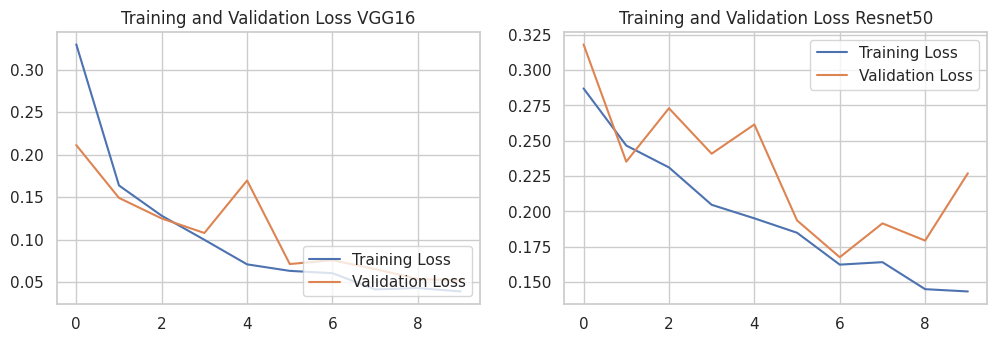

<Figure size 640x480 with 0 Axes>

In [257]:
plot_loss(brain_vgg16_model_fit,brain_renet50_model_fit, 'Brain Cancer')

## VGG16 VS Resnet50 Accuracy

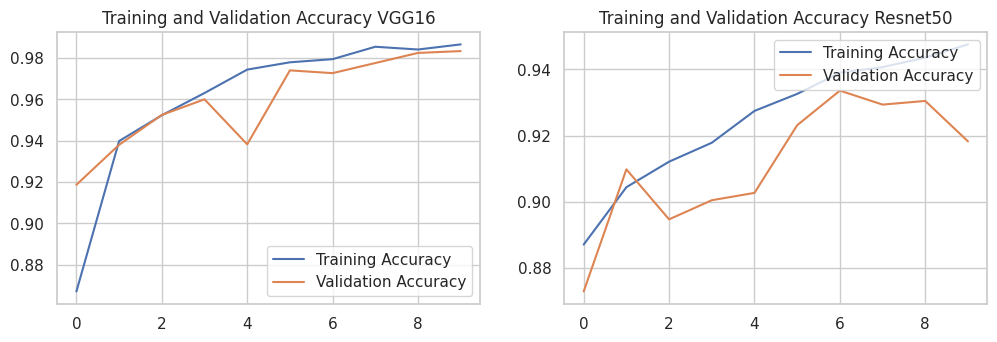

<Figure size 640x480 with 0 Axes>

In [258]:
plot_acc(brain_vgg16_model_fit,brain_renet50_model_fit, 'Brain Cancer')

## Breast Cancer

## VGG16 VS Resnet50 Loss

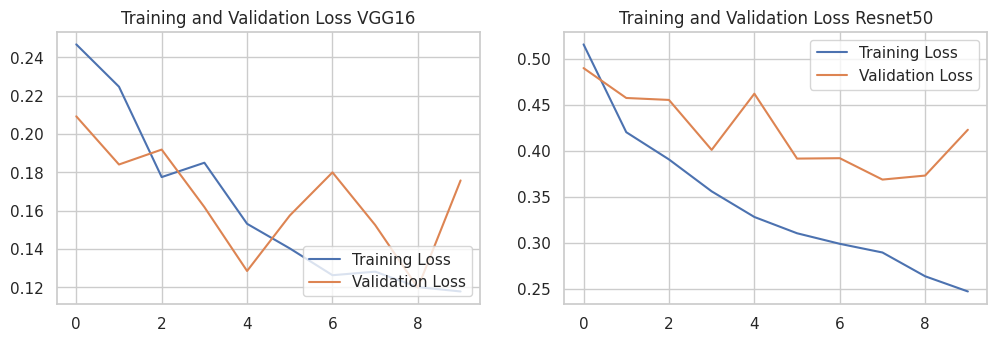

<Figure size 640x480 with 0 Axes>

In [259]:
plot_loss(breast_vgg_model_fit,breast_renet50_model_fit, 'Breast Cancer')

## VGG16 VS Resnet50 Accuracy

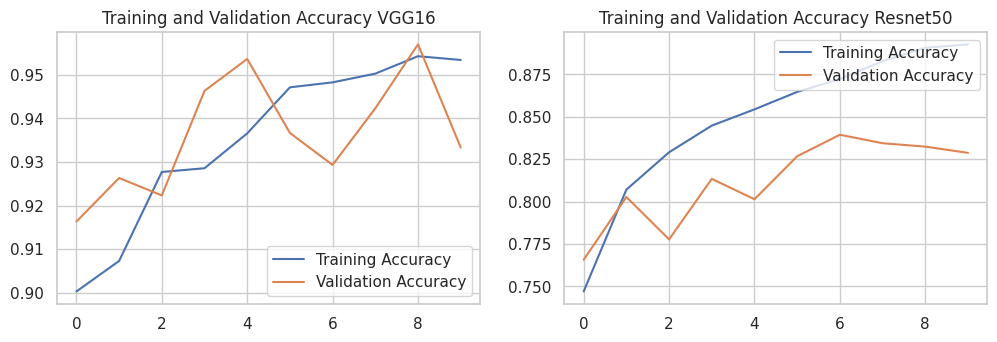

<Figure size 640x480 with 0 Axes>

In [260]:
plot_acc(breast_vgg_model_fit,breast_renet50_model_fit, 'Brain Cancer')

## Cervical Cancer

## VGG16 VS Resnet50 Loss

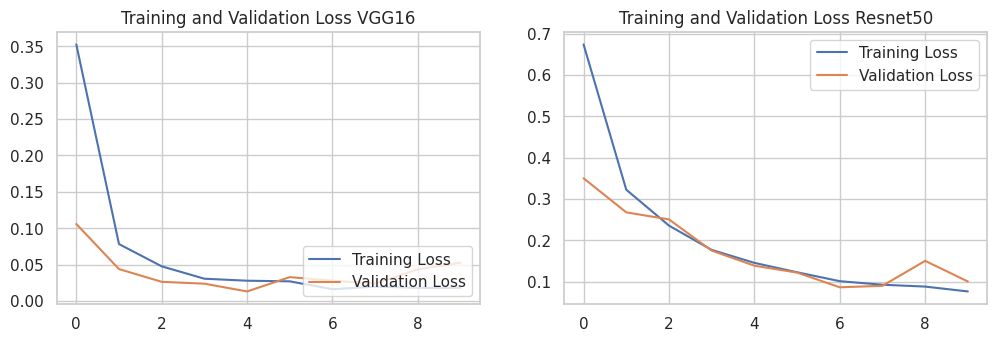

<Figure size 640x480 with 0 Axes>

In [261]:
plot_loss(Cervical_vgg_model_fit,Cervical_renet50_model_fit, 'Cervical Cancer')

## VGG16 VS Resnet50 Accuracy

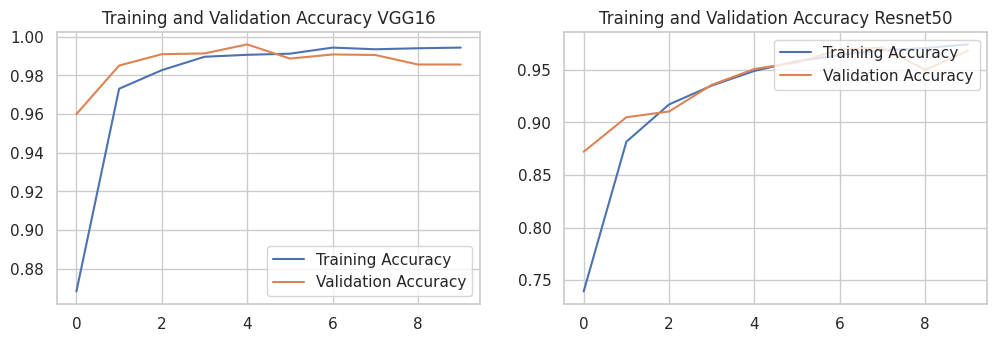

<Figure size 640x480 with 0 Axes>

In [262]:
plot_acc(Cervical_vgg_model_fit,Cervical_renet50_model_fit, 'Cervical Cancer')

## Kidney Cancer

## VGG16 VS Resnet50 Loss

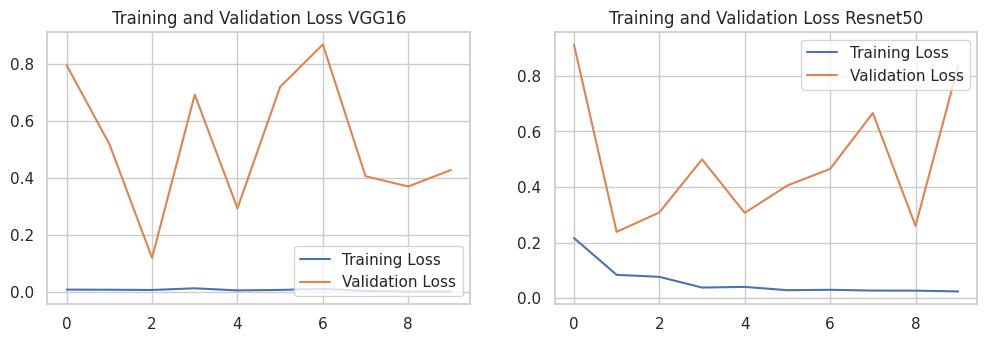

<Figure size 640x480 with 0 Axes>

In [263]:
plot_loss(Kidney_vgg_model_fit,Kidney_renet50_model_fit, 'Kidney Cancer')

## VGG16 VS Resnet50 Accuracy

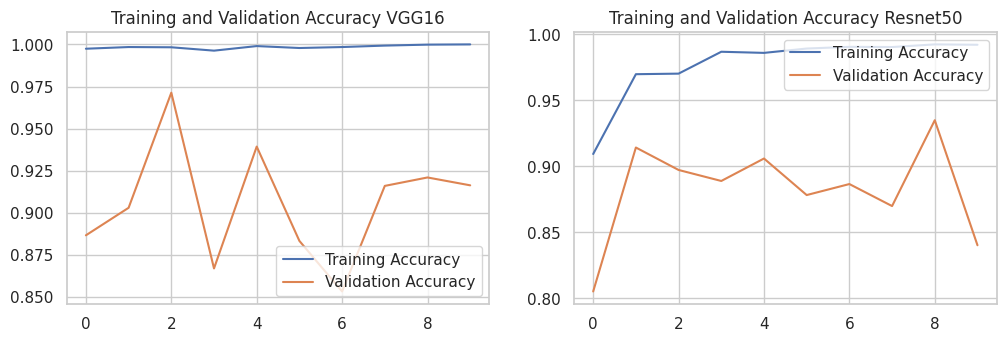

<Figure size 640x480 with 0 Axes>

In [264]:
plot_acc(Kidney_vgg_model_fit,Kidney_renet50_model_fit, 'Kidney Cancer')

## Lung and Colon Cancer

## VGG16 VS Resnet50 Loss

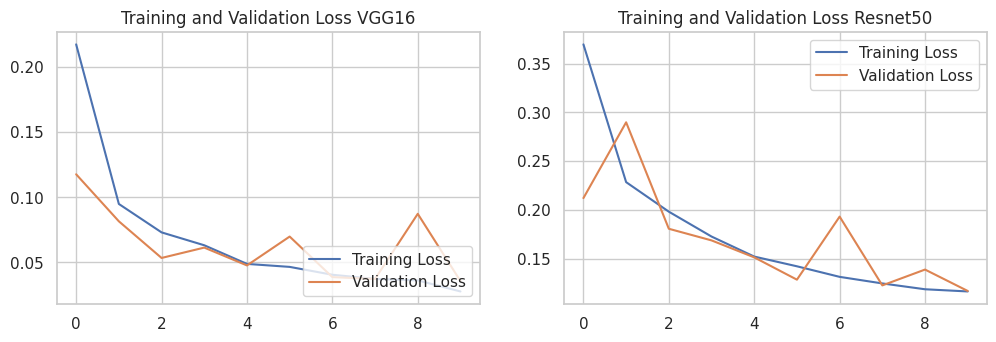

<Figure size 640x480 with 0 Axes>

In [265]:
plot_loss(Lung_and_Colon_vgg_model_fit,Lung_and_Colon_renet50_model_fit, 'Lung and Colon Cancer')

## VGG16 VS Resnet50 Accuracy

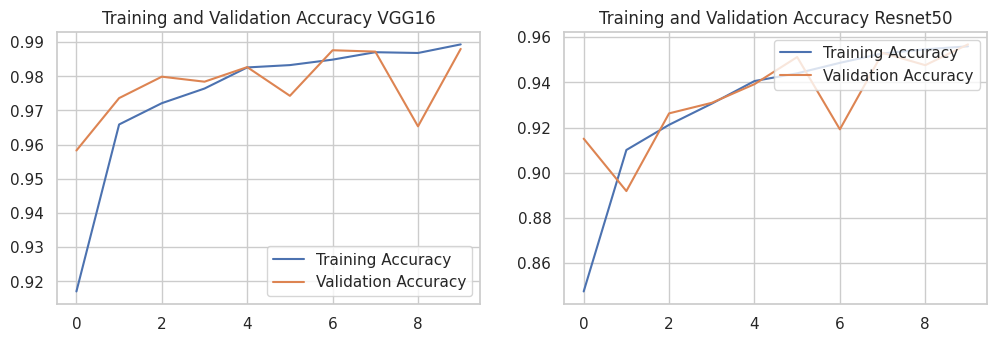

<Figure size 640x480 with 0 Axes>

In [266]:
plot_acc(Lung_and_Colon_vgg_model_fit,Lung_and_Colon_renet50_model_fit, 'Lung and Colon Cancer')

## Lymphoma Cancer

## VGG16 VS Resnet50 Loss

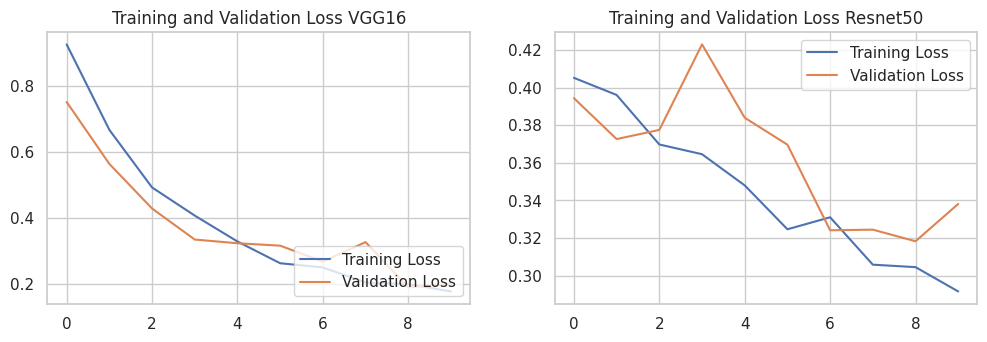

<Figure size 640x480 with 0 Axes>

In [267]:
plot_loss(Lymphoma_vgg_model_fit,Lymphoma_renet50_model_fit, 'Lymphoma Cancer')

## VGG16 VS Resnet50 Accuracy

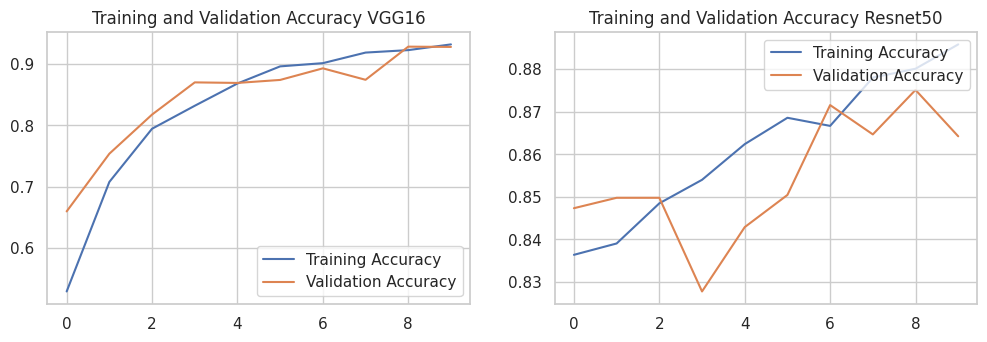

<Figure size 640x480 with 0 Axes>

In [268]:
plot_acc(Lymphoma_vgg_model_fit,Lymphoma_renet50_model_fit, 'Lymphoma Cancer')

## Oral Cancer

## VGG16 VS Resnet50 Loss

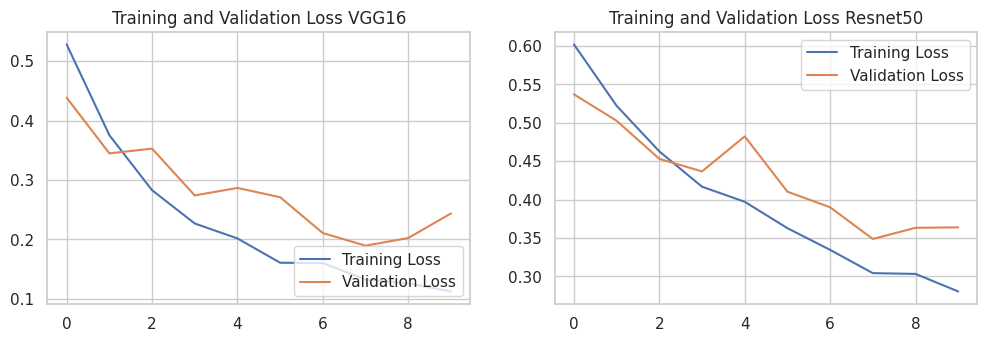

<Figure size 640x480 with 0 Axes>

In [269]:
plot_loss(oral_vgg_model_fit,oral_renet50_model_fit, 'Oral Cancer')

## VGG16 VS Resnet50 Accuracy

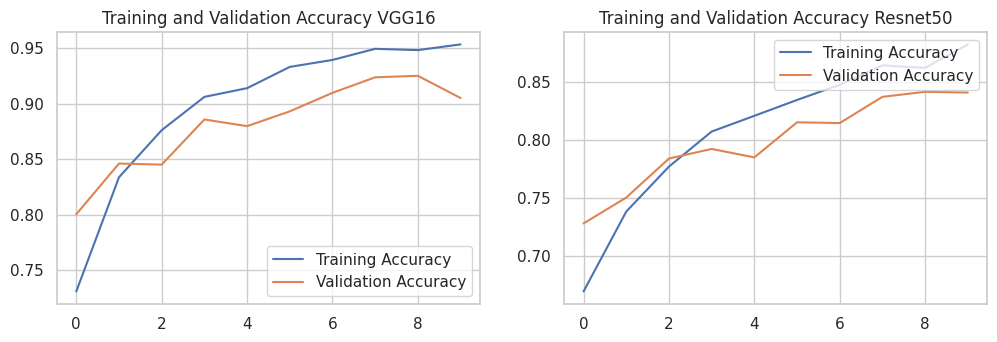

<Figure size 640x480 with 0 Axes>

In [270]:
plot_acc(oral_vgg_model_fit,oral_renet50_model_fit, 'Oral Cancer')

## Acute Lymphoblastic Leukemia Cancer

## VGG16 VS Resnet50 Loss

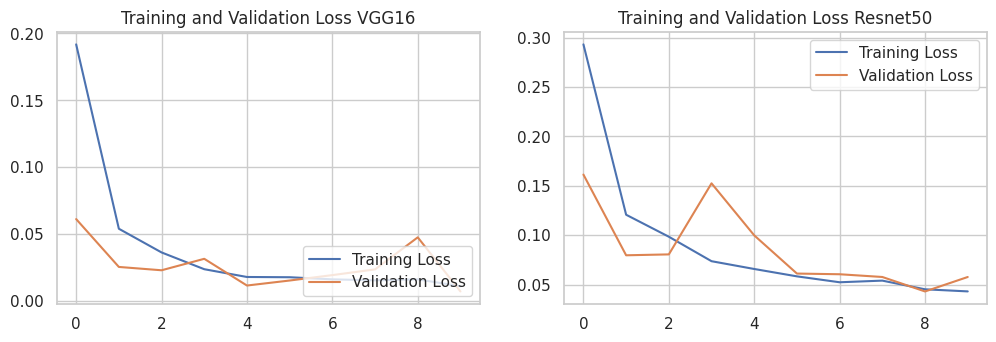

<Figure size 640x480 with 0 Axes>

In [271]:
plot_loss(all_vgg_model_fit,all_renet50_model_fit, 'all Cancer')

## VGG16 VS Resnet50 Accuracy

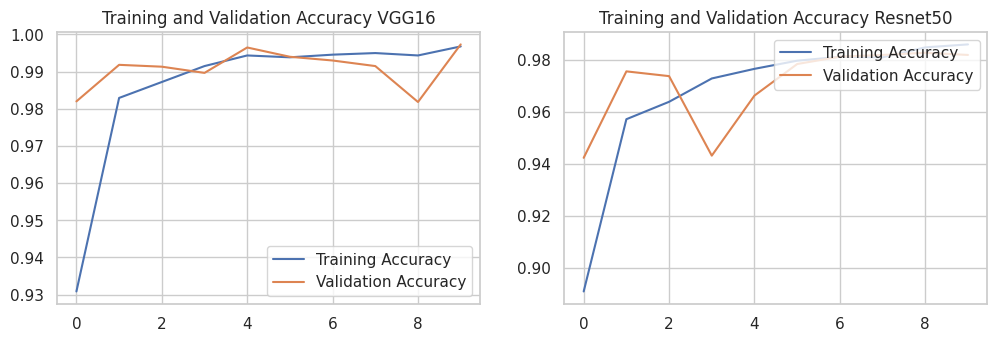

<Figure size 640x480 with 0 Axes>

In [272]:
plot_acc(all_vgg_model_fit,all_renet50_model_fit, 'all Cancer')